# Análisis de Clústeres — Matrimonios en Guatemala (2009-2022)

**Objetivo:** Identificar perfiles demográficos y socioculturales de las parejas que contraen matrimonio en Guatemala mediante técnicas de agrupamiento no supervisado.

Se aplican **tres algoritmos** de clustering:

| Algoritmo | Tipo | Complejidad | Ventaja principal |
|---|---|---|---|
| **K-Means** | Partición (centroides) | O(n·k·i) | Escalable a datasets grandes |
| **Jerárquico Aglomerativo** | Jerárquico (dendrograma) | O(n²) memoria | Revela estructura anidada |
| **DBSCAN** | Basado en densidad | O(n log n) con índice | Detecta formas arbitrarias y ruido |

Se comparan los tres modelos y se interpretan los resultados del que mejor se ajuste a los datos.

In [16]:
# ── Imports ──────────────────────────────────────────────────────────────
import warnings, pathlib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (silhouette_score, silhouette_samples,
                             davies_bouldin_score, calinski_harabasz_score)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors

# Scipy – clustering jerárquico
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import pdist

# Config global
plt.rcParams.update({"figure.dpi": 120, "axes.titlesize": 13,
                      "axes.labelsize": 11, "figure.figsize": (10, 5)})
sns.set_style("whitegrid")
SEED = 42
np.random.seed(SEED)

IMG_DIR = pathlib.Path("img/clustering")
IMG_DIR.mkdir(parents=True, exist_ok=True)

print("✔ Librerías cargadas correctamente.")

✔ Librerías cargadas correctamente.


In [20]:
# ── Carga de datos ───────────────────────────────────────────────────────
DATA_PATH = pathlib.Path("data/matrimonios_unified.sav")
df_raw, metadata = pyreadstat.read_sav(str(DATA_PATH))

# Convertir columnas de edad a numérico (vienen como string en el SPSS)
df_raw["edadhom"] = pd.to_numeric(df_raw["edadhom"], errors="coerce")
df_raw["edadmuj"] = pd.to_numeric(df_raw["edadmuj"], errors="coerce")

print(f"Registros cargados : {df_raw.shape[0]:,}")
print(f"Variables           : {df_raw.shape[1]}")
print(f"Columnas            : {list(df_raw.columns)}")
print(f"\nedadhom dtype: {df_raw['edadhom'].dtype}, edadmuj dtype: {df_raw['edadmuj'].dtype}")
df_raw.head(3)

Registros cargados : 1,055,847
Variables           : 15
Columnas            : ['depreg', 'mesreg', 'edadhom', 'edadmuj', 'pueblo_hombre', 'pueblo_mujer', 'nupcialidad_hombre', 'nupcialidad_mujer', 'depocu', 'mesocu', 'area_geografica', 'eschom', 'escmuj', 'areagocu', 'year']

edadhom dtype: float64, edadmuj dtype: float64


,depreg,mesreg,edadhom,edadmuj,pueblo_hombre,pueblo_mujer,nupcialidad_hombre,nupcialidad_mujer,depocu,mesocu,area_geografica,eschom,escmuj,areagocu,year
0,San Marcos,Abril,16.0,14.0,Indigena,Indigena,Ignorado,Ignorado,San Marcos,Septiembre,Ignorado,Ignorado,Ignorado,Ignorado,2009.0
1,Retalhuleu,Mayo,16.0,14.0,Ignorado,Ignorado,Ignorado,Ignorado,Retalhuleu,Marzo,Ignorado,Ignorado,Ignorado,Ignorado,2009.0
2,Huehuetenango,Enero,16.0,14.0,Ignorado,Ignorado,1.0,1.0,Huehuetenango,Diciembre,Ignorado,Ignorado,Ignorado,Ignorado,2009.0


---
## 2. Análisis Exploratorio de Datos (EDA)

Antes de aplicar cualquier algoritmo de clustering, es necesario comprender la estructura, distribución y calidad de los datos. En esta sección se revisan:

1. **Tipología y valores faltantes** de cada variable.
2. **Estadísticos descriptivos** de las variables numéricas.
3. **Detección de outliers** mediante IQR y boxplots.
4. **Matriz de correlación** para identificar redundancias y relaciones lineales.

> **Nota:** El EDA completo con análisis de frecuencias, normalidad, estacionalidad y tendencias temporales se encuentra en `analysis.ipynb`. Aquí se presenta un resumen orientado a las decisiones de preprocesamiento para clustering.

In [21]:
# ── 2a. Tipos de dato, nulos y estadísticos ──────────────────────────────
print("═" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("═" * 60)

# Tipos y nulos
info_df = pd.DataFrame({
    "dtype": df_raw.dtypes,
    "no_nulos": df_raw.notna().sum(),
    "nulos": df_raw.isna().sum(),
    "% nulos": (df_raw.isna().mean() * 100).round(2)
})
print(info_df.to_string())

print(f"\n→ Total registros: {len(df_raw):,}")
print(f"→ Variables con nulos: {(df_raw.isna().any()).sum()}")

# Estadísticos descriptivos de variables numéricas
print("\n" + "═" * 60)
print("ESTADÍSTICOS DESCRIPTIVOS (numéricas)")
print("═" * 60)
df_raw.describe().T.round(2)

════════════════════════════════════════════════════════════
INFORMACIÓN GENERAL DEL DATASET
════════════════════════════════════════════════════════════
                      dtype  no_nulos  nulos  % nulos
depreg                  str   1055847      0     0.00
mesreg                  str   1055847      0     0.00
edadhom             float64   1053020   2827     0.27
edadmuj             float64   1052690   3157     0.30
pueblo_hombre           str   1055847      0     0.00
pueblo_mujer            str   1055847      0     0.00
nupcialidad_hombre      str   1055847      0     0.00
nupcialidad_mujer       str   1055847      0     0.00
depocu                  str   1055847      0     0.00
mesocu                  str   1055847      0     0.00
area_geografica         str   1055847      0     0.00
eschom                  str   1055847      0     0.00
escmuj                  str   1055847      0     0.00
areagocu                str   1055847      0     0.00
year                float64   105584

,count,mean,std,min,25%,50%,75%,max
edadhom,1053020.0,29.48,11.33,12.0,22.0,26.0,33.0,99.0
edadmuj,1052690.0,26.47,10.01,10.0,20.0,24.0,29.0,109.0
year,1055847.0,2015.55,4.01,2009.0,2012.0,2015.0,2019.0,2022.0


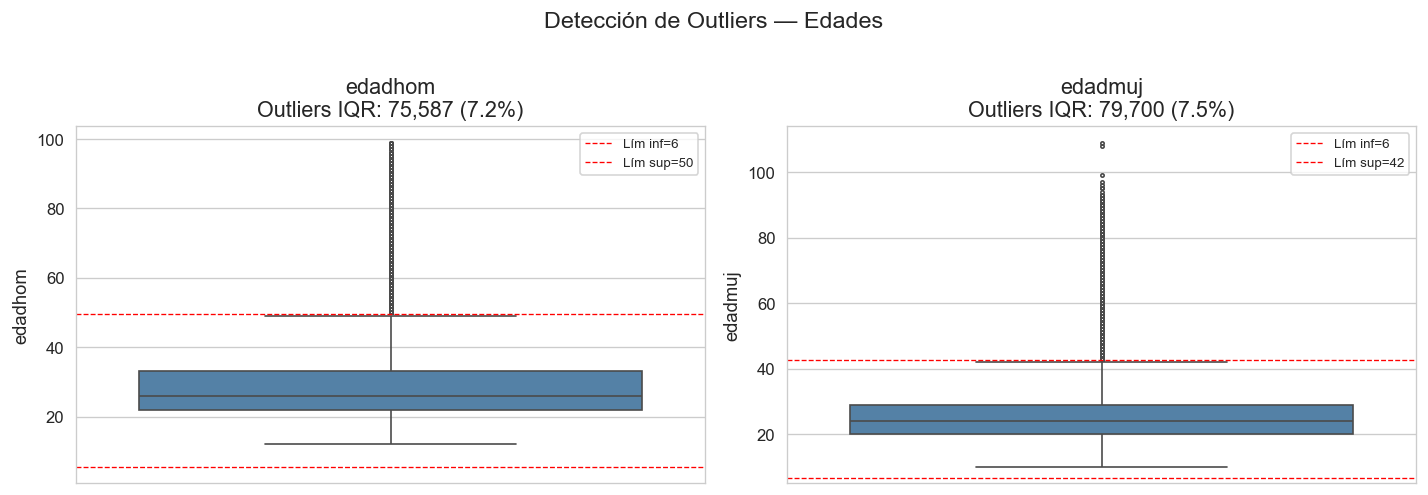

  edadhom: Q1=22, Q3=33, IQR=11, rango aceptable=[6, 50], outliers=75,587
  edadmuj: Q1=20, Q3=29, IQR=9, rango aceptable=[6, 42], outliers=79,700

→ Los outliers de edad representan matrimonios con diferencias de edad atípicas. Se conservan porque son registros reales del INE.


In [22]:
# ── 2b. Detección de outliers (IQR) y boxplots ───────────────────────────
num_cols = ["edadhom", "edadmuj"]

fig, axes = plt.subplots(1, len(num_cols), figsize=(12, 4))
for ax, col in zip(axes, num_cols):
    Q1, Q3 = df_raw[col].quantile(0.25), df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((df_raw[col] < low) | (df_raw[col] > high)).sum()
    pct_out = n_out / len(df_raw) * 100
    sns.boxplot(y=df_raw[col], ax=ax, color="steelblue", fliersize=2)
    ax.set_title(f"{col}\nOutliers IQR: {n_out:,} ({pct_out:.1f}%)")
    ax.axhline(low, ls="--", color="red", lw=0.8, label=f"Lím inf={low:.0f}")
    ax.axhline(high, ls="--", color="red", lw=0.8, label=f"Lím sup={high:.0f}")
    ax.legend(fontsize=8)

plt.suptitle("Detección de Outliers — Edades", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(IMG_DIR / "eda_boxplots_outliers.png", bbox_inches="tight")
plt.show()

# Resumen numérico de outliers
for col in num_cols:
    Q1, Q3 = df_raw[col].quantile(0.25), df_raw[col].quantile(0.75)
    IQR = Q3 - Q1
    low, high = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n_out = ((df_raw[col] < low) | (df_raw[col] > high)).sum()
    print(f"  {col}: Q1={Q1:.0f}, Q3={Q3:.0f}, IQR={IQR:.0f}, "
          f"rango aceptable=[{low:.0f}, {high:.0f}], outliers={n_out:,}")
print("\n→ Los outliers de edad representan matrimonios con diferencias"
      " de edad atípicas. Se conservan porque son registros reales del INE.")

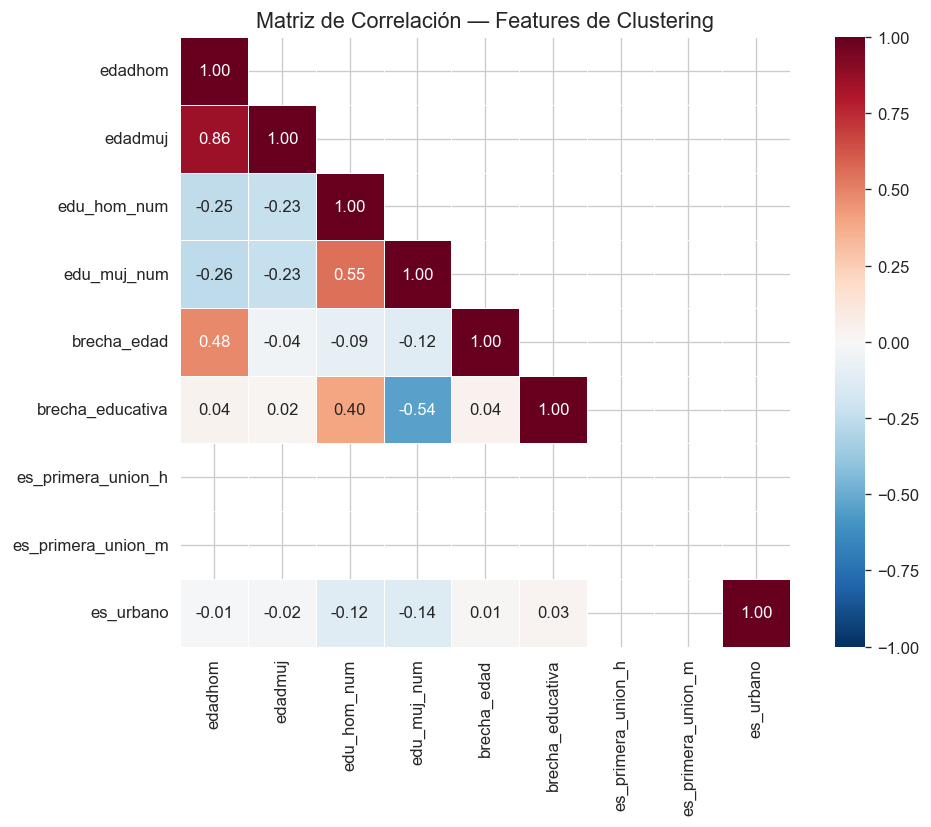

Observaciones clave:
  • edadhom ↔ edadmuj: correlación alta → ambas aportan info complementaria con brecha_edad
  • edu_hom_num ↔ edu_muj_num: correlación alta → homogamia educativa
  • es_primera_union: inversamente correlacionado con edad (a mayor edad, más re-nupcias)


In [23]:
# ── 2c. Matriz de correlación (variables numéricas del dataset crudo) ─────
# Primero creamos las mismas features numéricas que usaremos para clustering
# para ver su correlación antes de escalar.

# Mapeo de escolaridad a años (ordinal → numérico)
educacion_map = {
    "Ninguno": 0, "Pre-primaria": 2, "Primaria": 6,
    "Basico": 9, "Diversificado": 12, "Superior": 16
}

# Crear copia temporal con features derivadas
_tmp = df_raw.copy()
_tmp["edu_hom_num"] = _tmp["eschom"].map(educacion_map)
_tmp["edu_muj_num"] = _tmp["escmuj"].map(educacion_map)
_tmp["brecha_edad"] = _tmp["edadhom"] - _tmp["edadmuj"]
_tmp["brecha_educativa"] = _tmp["edu_hom_num"] - _tmp["edu_muj_num"]
_tmp["es_primera_union_h"] = (_tmp["nupcialidad_hombre"] == "Primera vez").astype(int)
_tmp["es_primera_union_m"] = (_tmp["nupcialidad_mujer"] == "Primera vez").astype(int)
_tmp["es_urbano"] = (_tmp["area_geografica"] == "Urbano").astype(int)

corr_cols = ["edadhom", "edadmuj", "edu_hom_num", "edu_muj_num",
             "brecha_edad", "brecha_educativa",
             "es_primera_union_h", "es_primera_union_m", "es_urbano"]
corr_matrix = _tmp[corr_cols].dropna().corr()

fig, ax = plt.subplots(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="RdBu_r",
            center=0, vmin=-1, vmax=1, square=True, linewidths=0.5, ax=ax)
ax.set_title("Matriz de Correlación — Features de Clustering", fontsize=13)
plt.tight_layout()
plt.savefig(IMG_DIR / "eda_correlacion.png", bbox_inches="tight")
plt.show()

print("Observaciones clave:")
print("  • edadhom ↔ edadmuj: correlación alta → ambas aportan info complementaria con brecha_edad")
print("  • edu_hom_num ↔ edu_muj_num: correlación alta → homogamia educativa")
print("  • es_primera_union: inversamente correlacionado con edad (a mayor edad, más re-nupcias)")
del _tmp

---
## 3. Preprocesamiento para Clustering

### 3.1 Ingeniería de Features

Se transforman las 15 variables originales en **9 features numéricas** aptas para algoritmos basados en distancia:

| Feature | Origen | Tipo | Justificación |
|---|---|---|---|
| `edadhom` | Directa | Continua | Edad del hombre al momento del matrimonio |
| `edadmuj` | Directa | Continua | Edad de la mujer al momento del matrimonio |
| `edu_hom_num` | `eschom` → ordinal a años | Ordinal numérica | Nivel de escolaridad codificado (0–16 años) |
| `edu_muj_num` | `escmuj` → ordinal a años | Ordinal numérica | Idem para la mujer |
| `brecha_edad` | `edadhom - edadmuj` | Derivada | Diferencia de edad (positiva = hombre mayor) |
| `brecha_educativa` | `edu_hom - edu_muj` | Derivada | Diferencia educativa entre cónyuges |
| `es_primera_union_h` | `nupcialidad_hombre` | Binaria | 1 = primera unión, 0 = re-nupcial |
| `es_primera_union_m` | `nupcialidad_mujer` | Binaria | 1 = primera unión, 0 = re-nupcial |
| `es_urbano` | `area_geografica` | Binaria | 1 = urbano, 0 = rural |

### 3.2 Justificación del escalado

Se aplica **StandardScaler (Z-score)** por las siguientes razones:
- K-Means y clustering jerárquico utilizan **distancia euclidiana**, que es sensible a diferencias de escala.
- Las edades (0–100) y las variables binarias (0–1) están en rangos incomparables.
- El Z-score centra en media 0 y desviación 1, dando **peso equitativo** a cada feature.
- No se aplica One-Hot Encoding porque generaría muchas columnas sparse que distorsionan la distancia euclidiana en K-Means.

### 3.3 Filtrado de registros incompletos
Se eliminan registros con valores faltantes en las features seleccionadas.

In [29]:
# ── 3a. Ingeniería de features ────────────────────────────────────────────
df = df_raw.copy()

# Mapeo de escolaridad a años (Ignorado → NaN → se eliminará)
educacion_map = {
    "Ninguno": 0, "Pre-primaria": 2, "Primaria": 6,
    "Basico": 9, "Diversificado": 12, "Superior": 16
}
df["edu_hom_num"] = df["eschom"].map(educacion_map)
df["edu_muj_num"] = df["escmuj"].map(educacion_map)

# Features derivadas
df["brecha_edad"] = df["edadhom"] - df["edadmuj"]
df["brecha_educativa"] = df["edu_hom_num"] - df["edu_muj_num"]

# Nupcialidad: "1.0" en SPSS = primera unión
# "Ignorado" y "" → se tratan como no-primera-unión (0) para preservar datos.
# Justificación: 79% de los registros tienen nupcialidad desconocida;
# eliminarlos destruiría la representatividad de la muestra.
df["es_primera_union_h"] = (df["nupcialidad_hombre"] == "1.0").astype(int)
df["es_primera_union_m"] = (df["nupcialidad_mujer"] == "1.0").astype(int)

# Área geográfica: Urbano=1, Rural/Ignorado=0
df["es_urbano"] = (df["area_geografica"] == "Urbano").astype(int)

# Lista de features finales
features = [
    "edadhom", "edadmuj",
    "edu_hom_num", "edu_muj_num",
    "brecha_edad", "brecha_educativa",
    "es_primera_union_h", "es_primera_union_m",
    "es_urbano"
]

# Solo filtrar NaN genuinos (edades no numéricas + escolaridad "Ignorado")
n_antes = len(df)
df = df.dropna(subset=features)
n_despues = len(df)
print(f"Registros antes de filtrar : {n_antes:,}")
print(f"Registros después          : {n_despues:,}")
print(f"Eliminados por nulos       : {n_antes - n_despues:,} "
      f"({(n_antes - n_despues)/n_antes*100:.1f}%)")

# Verificar distribución de features binarias
print(f"\nes_primera_union_h: {df['es_primera_union_h'].value_counts().to_dict()}")
print(f"es_primera_union_m: {df['es_primera_union_m'].value_counts().to_dict()}")
print(f"es_urbano: {df['es_urbano'].value_counts().to_dict()}")

print(f"\nFeatures seleccionadas ({len(features)}):")
for i, f in enumerate(features, 1):
    print(f"  {i}. {f}")

df = df.reset_index(drop=True)

Registros antes de filtrar : 1,055,847
Registros después          : 837,158
Eliminados por nulos       : 218,689 (20.7%)

es_primera_union_h: {0: 660150, 1: 177008}
es_primera_union_m: {0: 659296, 1: 177862}
es_urbano: {0: 448483, 1: 388675}

Features seleccionadas (9):
  1. edadhom
  2. edadmuj
  3. edu_hom_num
  4. edu_muj_num
  5. brecha_edad
  6. brecha_educativa
  7. es_primera_union_h
  8. es_primera_union_m
  9. es_urbano


In [30]:
# ── 3b. Escalado Z-score ──────────────────────────────────────────────────
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])

# Verificación: media ≈ 0, std ≈ 1
stats_scaled = pd.DataFrame(X_scaled, columns=features).describe().loc[["mean", "std"]].T
stats_scaled.columns = ["media_escalada", "std_escalada"]
print("Verificación del escalado (Z-score):")
print(stats_scaled.round(4).to_string())
print(f"\nMatriz final: {X_scaled.shape[0]:,} registros × {X_scaled.shape[1]} features")

# ── 3c. Muestra compartida para comparación justa ────────────────────────
# Hierarchical (O(n²)) y DBSCAN requieren muestras más pequeñas.
# Usamos UNA SOLA muestra de 15,000 registros para evaluar los 3 algoritmos
# con métricas comparables. K-Means adicionalmente se entrena en todo el dataset.

N_SAMPLE = 15_000
idx_sample = np.random.choice(len(X_scaled), size=N_SAMPLE, replace=False)
X_sample = X_scaled[idx_sample]

print(f"\n✔ Muestra compartida para comparación: {N_SAMPLE:,} registros (seed={SEED})")

Verificación del escalado (Z-score):
                    media_escalada  std_escalada
edadhom                        0.0           1.0
edadmuj                       -0.0           1.0
edu_hom_num                    0.0           1.0
edu_muj_num                    0.0           1.0
brecha_edad                    0.0           1.0
brecha_educativa               0.0           1.0
es_primera_union_h            -0.0           1.0
es_primera_union_m             0.0           1.0
es_urbano                      0.0           1.0

Matriz final: 837,158 registros × 9 features

✔ Muestra compartida para comparación: 15,000 registros (seed=42)


---
## 4. K-Means Clustering

### Fundamento teórico
K-Means es un algoritmo de **partición por centroides** que minimiza la inercia (suma de distancias cuadradas intra-clúster). Sus supuestos son:
- Clústeres **esféricos** y de tamaño similar.
- Requiere especificar **K** a priori.
- Sensible a la escala → justifica el Z-score aplicado.

### Selección de K
Se utilizan tres criterios complementarios:
1. **Método del codo (Elbow):** punto de inflexión en la curva de inercia.
2. **Coeficiente de Silhouette:** mide cohesión vs. separación (max → mejor).
3. **Davies-Bouldin Index:** mide similitud entre clústeres (min → mejor).
4. **Calinski-Harabasz Index:** ratio varianza inter/intra (max → mejor).

In [31]:
# ── 4a. Selección de K: Método del Codo + Métricas múltiples ─────────────
k_values = list(range(2, 11))
inertias, sil_scores, db_scores, ch_scores = [], [], [], []

# Usar una muestra de 50K para las métricas (rápido y representativo)
N_METRIC = min(50_000, len(X_scaled))
idx_metric = np.random.choice(len(X_scaled), size=N_METRIC, replace=False)
X_metric = X_scaled[idx_metric]

print(f"Evaluando K de {k_values[0]} a {k_values[-1]} sobre {N_METRIC:,} registros...")
for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=SEED)
    labels = km.fit_predict(X_metric)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_metric, labels))
    db_scores.append(davies_bouldin_score(X_metric, labels))
    ch_scores.append(calinski_harabasz_score(X_metric, labels))
    print(f"  K={k}: Silhouette={sil_scores[-1]:.4f}, DB={db_scores[-1]:.4f}, "
          f"CH={ch_scores[-1]:,.0f}, Inercia={inertias[-1]:,.0f}")

# Identificar mejores K por cada métrica
best_sil_k = k_values[np.argmax(sil_scores)]
best_db_k  = k_values[np.argmin(db_scores)]
best_ch_k  = k_values[np.argmax(ch_scores)]
print(f"\n→ Mejor K por Silhouette : {best_sil_k}")
print(f"→ Mejor K por Davies-Bouldin: {best_db_k}")
print(f"→ Mejor K por Calinski-Harabasz: {best_ch_k}")

Evaluando K de 2 a 10 sobre 50,000 registros...
  K=2: Silhouette=0.3127, DB=1.3791, CH=14,410, Inercia=349,368
  K=3: Silhouette=0.3283, DB=1.3113, CH=14,833, Inercia=282,459
  K=4: Silhouette=0.2498, DB=1.4566, CH=14,245, Inercia=242,648
  K=5: Silhouette=0.2618, DB=1.3778, CH=13,498, Inercia=216,378
  K=6: Silhouette=0.2742, DB=1.2527, CH=12,915, Inercia=196,387
  K=7: Silhouette=0.2564, DB=1.3144, CH=11,549, Inercia=188,616
  K=8: Silhouette=0.2855, DB=1.2917, CH=11,237, Inercia=174,887
  K=9: Silhouette=0.2562, DB=1.4707, CH=10,625, Inercia=166,672
  K=10: Silhouette=0.2751, DB=1.4007, CH=10,172, Inercia=158,960

→ Mejor K por Silhouette : 3
→ Mejor K por Davies-Bouldin: 6
→ Mejor K por Calinski-Harabasz: 3


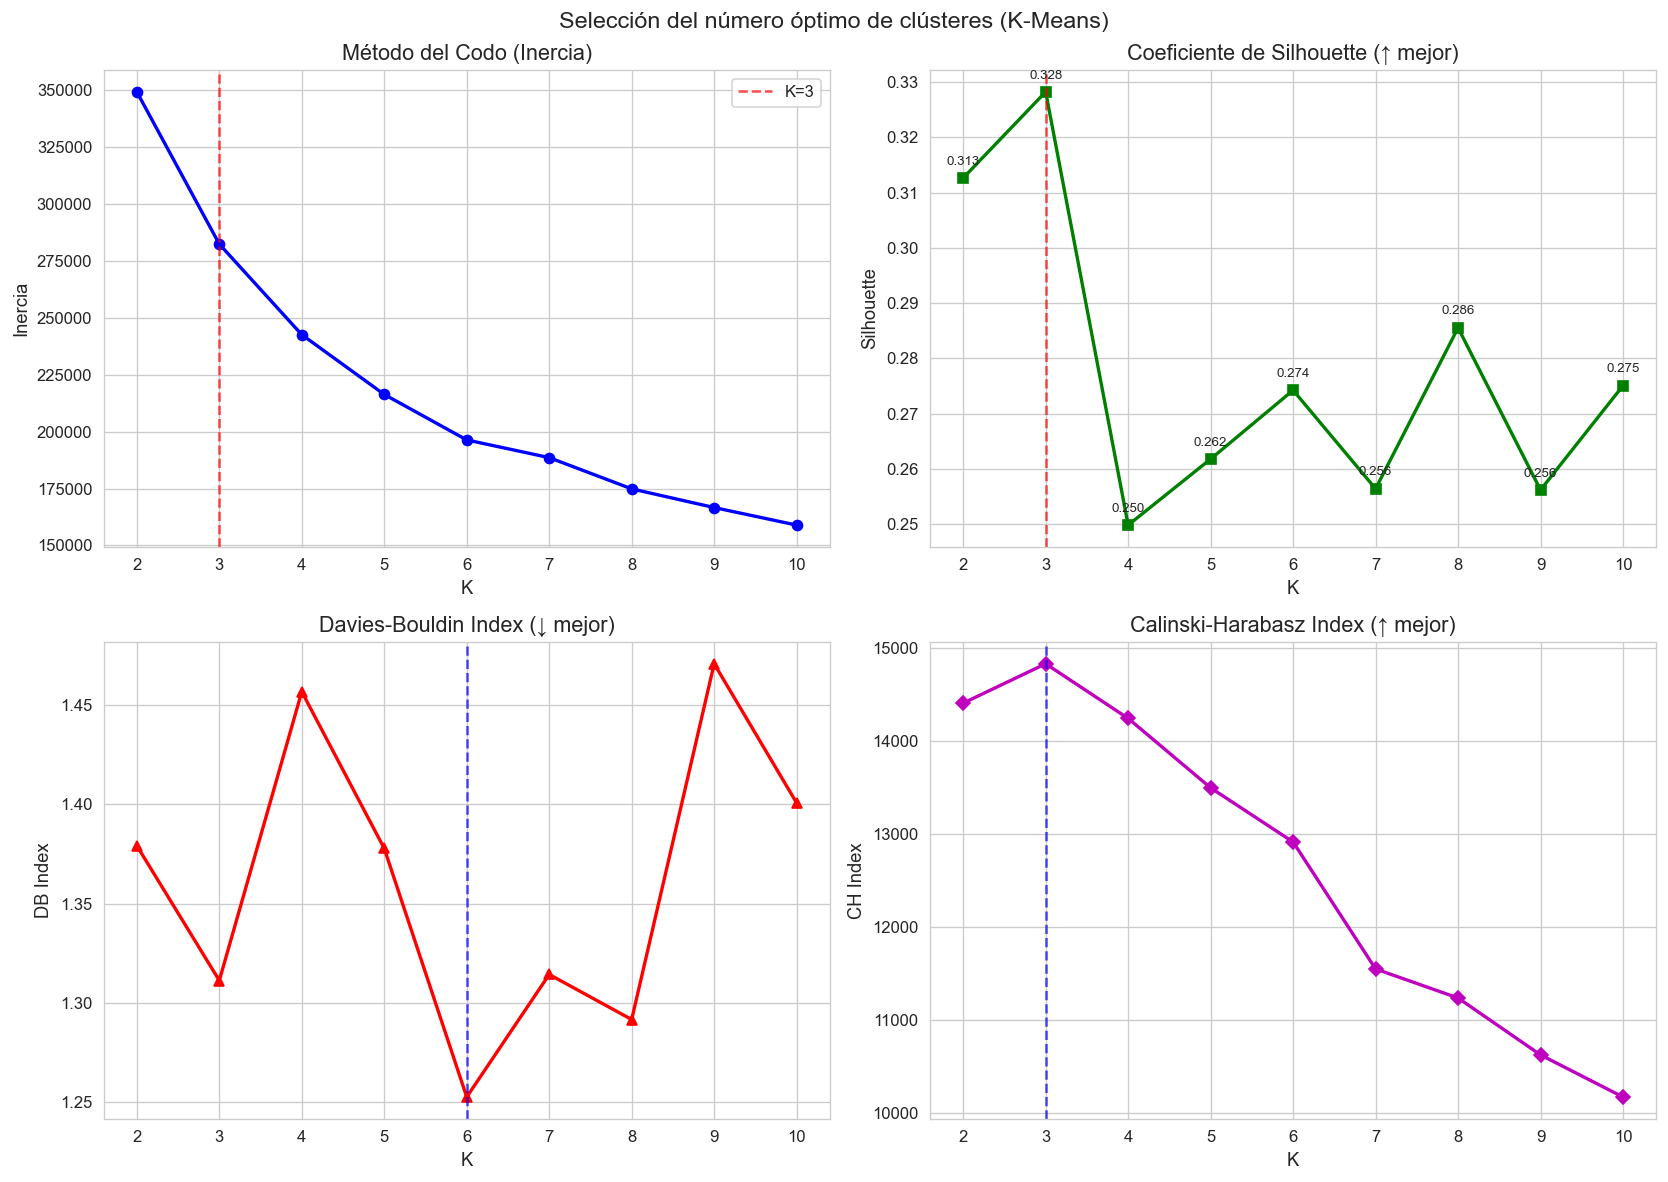

In [32]:
# ── 4b. Visualización de métricas ─────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow
axes[0, 0].plot(k_values, inertias, "bo-", linewidth=2, markersize=6)
axes[0, 0].set_title("Método del Codo (Inercia)")
axes[0, 0].set_xlabel("K"); axes[0, 0].set_ylabel("Inercia")
axes[0, 0].axvline(best_sil_k, color="red", ls="--", alpha=0.7, label=f"K={best_sil_k}")
axes[0, 0].legend()

# Silhouette
axes[0, 1].plot(k_values, sil_scores, "gs-", linewidth=2, markersize=6)
axes[0, 1].set_title("Coeficiente de Silhouette (↑ mejor)")
axes[0, 1].set_xlabel("K"); axes[0, 1].set_ylabel("Silhouette")
axes[0, 1].axvline(best_sil_k, color="red", ls="--", alpha=0.7)
for i, v in enumerate(sil_scores):
    axes[0, 1].annotate(f"{v:.3f}", (k_values[i], v), textcoords="offset points",
                         xytext=(0, 8), ha="center", fontsize=8)

# Davies-Bouldin
axes[1, 0].plot(k_values, db_scores, "r^-", linewidth=2, markersize=6)
axes[1, 0].set_title("Davies-Bouldin Index (↓ mejor)")
axes[1, 0].set_xlabel("K"); axes[1, 0].set_ylabel("DB Index")
axes[1, 0].axvline(best_db_k, color="blue", ls="--", alpha=0.7)

# Calinski-Harabasz
axes[1, 1].plot(k_values, ch_scores, "mD-", linewidth=2, markersize=6)
axes[1, 1].set_title("Calinski-Harabasz Index (↑ mejor)")
axes[1, 1].set_xlabel("K"); axes[1, 1].set_ylabel("CH Index")
axes[1, 1].axvline(best_ch_k, color="blue", ls="--", alpha=0.7)

plt.suptitle("Selección del número óptimo de clústeres (K-Means)", fontsize=14)
plt.tight_layout()
plt.savefig(IMG_DIR / "kmeans_seleccion_k.png", bbox_inches="tight")
plt.show()

In [33]:
# ── 4c. Entrenamiento K-Means con K óptimo (dataset completo) ─────────────
# Se elige K basado en consenso de métricas (Silhouette máximo)
k_optimo = best_sil_k
print(f"K óptimo seleccionado: {k_optimo}")
print(f"  Silhouette = {sil_scores[k_values.index(k_optimo)]:.4f}")
print(f"  Davies-Bouldin = {db_scores[k_values.index(k_optimo)]:.4f}")
print(f"  Calinski-Harabasz = {ch_scores[k_values.index(k_optimo)]:,.0f}")

# Entrenar en todo el dataset
print(f"\nEntrenando K-Means (K={k_optimo}) sobre {len(X_scaled):,} registros...")
kmeans_final = KMeans(n_clusters=k_optimo, n_init=10, max_iter=300, random_state=SEED)
df["cluster_kmeans"] = kmeans_final.fit_predict(X_scaled)

# Distribución de clústeres
print("\nDistribución de clústeres K-Means:")
for c in range(k_optimo):
    n = (df["cluster_kmeans"] == c).sum()
    pct = n / len(df) * 100
    print(f"  Clúster {c}: {n:>8,} registros ({pct:5.1f}%)")

# Métricas finales sobre la muestra compartida
labels_km_sample = kmeans_final.predict(X_sample)
sil_km = silhouette_score(X_sample, labels_km_sample)
db_km = davies_bouldin_score(X_sample, labels_km_sample)
ch_km = calinski_harabasz_score(X_sample, labels_km_sample)
print(f"\nMétricas K-Means en muestra compartida (n={N_SAMPLE:,}):")
print(f"  Silhouette       = {sil_km:.4f}")
print(f"  Davies-Bouldin   = {db_km:.4f}")
print(f"  Calinski-Harabasz = {ch_km:,.2f}")

K óptimo seleccionado: 3
  Silhouette = 0.3283
  Davies-Bouldin = 1.3113
  Calinski-Harabasz = 14,833

Entrenando K-Means (K=3) sobre 837,158 registros...

Distribución de clústeres K-Means:
  Clúster 0:  103,721 registros ( 12.4%)
  Clúster 1:  567,659 registros ( 67.8%)
  Clúster 2:  165,778 registros ( 19.8%)

Métricas K-Means en muestra compartida (n=15,000):
  Silhouette       = 0.3279
  Davies-Bouldin   = 1.3153
  Calinski-Harabasz = 4,526.63


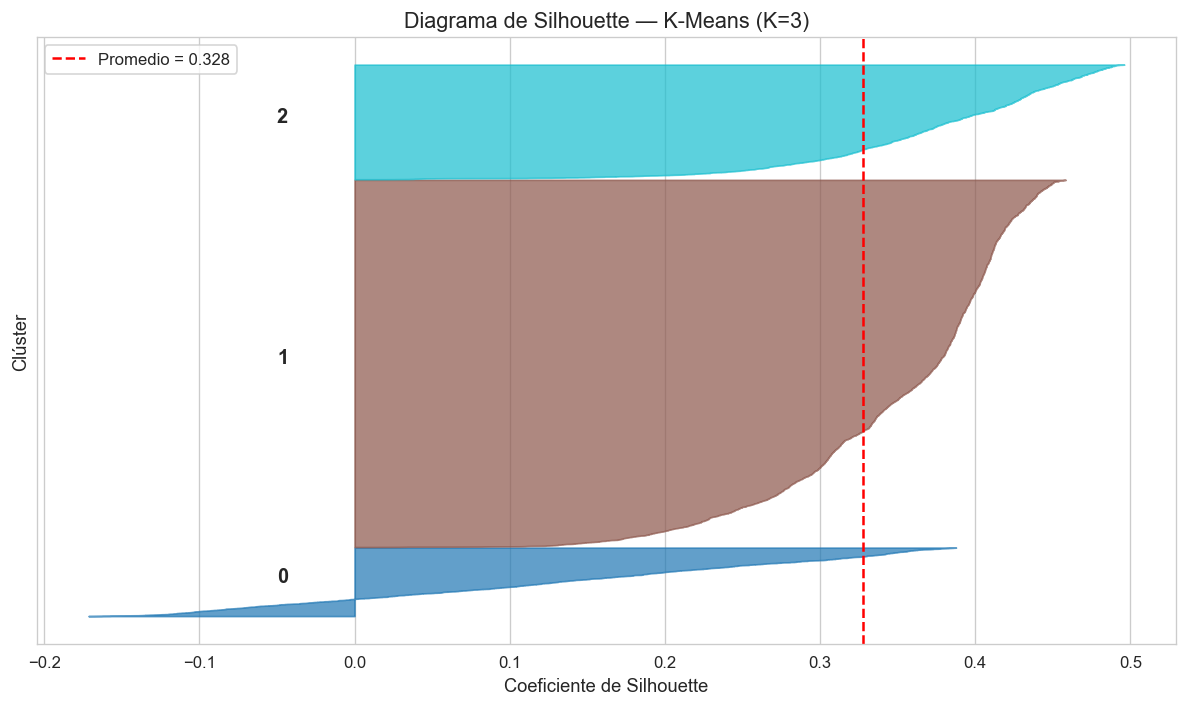

In [34]:
# ── 4d. Diagrama de Silhouette por clúster ────────────────────────────────
# Muestra cómo cada punto contribuye a la cohesión de su clúster
N_SIL_VIS = min(10_000, N_SAMPLE)
sil_vis_idx = np.random.choice(len(X_sample), size=N_SIL_VIS, replace=False)
X_sil = X_sample[sil_vis_idx]
labels_sil = labels_km_sample[sil_vis_idx]
sample_sil_values = silhouette_samples(X_sil, labels_sil)

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
colors = plt.cm.tab10(np.linspace(0, 1, k_optimo))

for i in range(k_optimo):
    ith_values = sample_sil_values[labels_sil == i]
    ith_values.sort()
    size_cluster_i = ith_values.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_values,
                      facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=12, fontweight="bold")
    y_lower = y_upper + 10

ax.axvline(x=sil_km, color="red", linestyle="--", linewidth=1.5,
           label=f"Promedio = {sil_km:.3f}")
ax.set_title(f"Diagrama de Silhouette — K-Means (K={k_optimo})", fontsize=13)
ax.set_xlabel("Coeficiente de Silhouette")
ax.set_ylabel("Clúster")
ax.set_yticks([])
ax.legend(loc="best")
plt.tight_layout()
plt.savefig(IMG_DIR / "kmeans_silhouette_diagram.png", bbox_inches="tight")
plt.show()

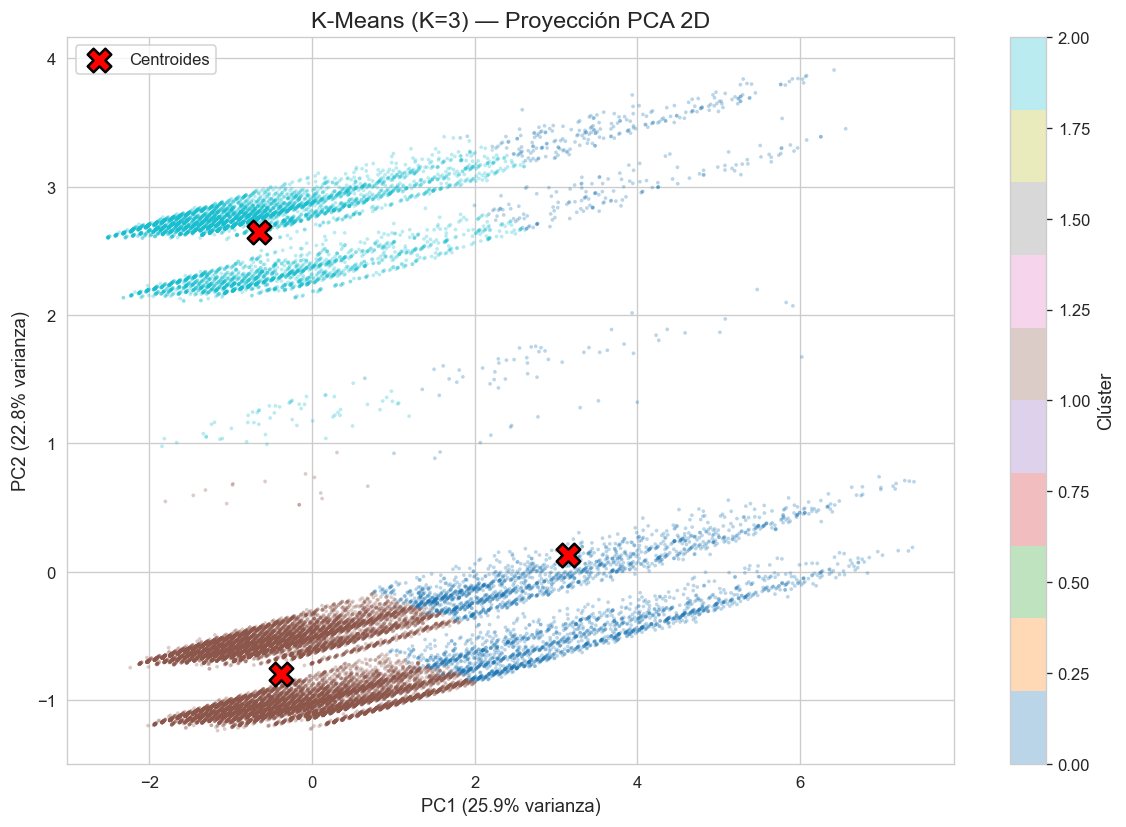

Loadings PCA (contribución de cada feature a los componentes):
                      PC1    PC2
edadhom             0.573  0.109
edadmuj             0.501  0.101
edu_hom_num        -0.375 -0.005
edu_muj_num        -0.429 -0.011
brecha_edad         0.257  0.039
brecha_educativa    0.095  0.007
es_primera_union_h -0.081  0.679
es_primera_union_m -0.078  0.679
es_urbano           0.094 -0.234


In [35]:
# ── 4e. Visualización PCA 2D — K-Means ────────────────────────────────────
pca = PCA(n_components=2, random_state=SEED)
X_pca_full = pca.fit_transform(X_scaled)

# Visualizar sobre una sub-muestra para claridad
N_VIS = min(30_000, len(X_scaled))
vis_idx = np.random.choice(len(X_scaled), size=N_VIS, replace=False)

fig, ax = plt.subplots(figsize=(10, 7))
scatter = ax.scatter(X_pca_full[vis_idx, 0], X_pca_full[vis_idx, 1],
                     c=df["cluster_kmeans"].values[vis_idx],
                     cmap="tab10", alpha=0.3, s=5, edgecolors="none")

# Centroides en espacio PCA
centroids_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
           c="red", marker="X", s=200, edgecolors="black", linewidths=1.5,
           label="Centroides", zorder=5)

ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% varianza)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% varianza)")
ax.set_title(f"K-Means (K={k_optimo}) — Proyección PCA 2D", fontsize=14)
ax.legend()
plt.colorbar(scatter, ax=ax, label="Clúster")
plt.tight_layout()
plt.savefig(IMG_DIR / "kmeans_pca2d.png", bbox_inches="tight")
plt.show()

# Loadings PCA (contribución de cada feature)
loadings = pd.DataFrame(pca.components_.T, index=features, columns=["PC1", "PC2"])
print("Loadings PCA (contribución de cada feature a los componentes):")
print(loadings.round(3).to_string())

---
## 5. Clustering Jerárquico Aglomerativo

### Fundamento teórico
El clustering jerárquico aglomerativo construye una **jerarquía de clústeres** fusionando iterativamente los pares más cercanos. A diferencia de K-Means:
- **No requiere especificar K** a priori (se elige cortando el dendrograma).
- Revela la **estructura anidada** de los datos.
- Utiliza una **matriz de distancias** completa → complejidad O(n²) en memoria.

### Método de enlace: Ward
Se utiliza el **criterio de Ward** (mínima varianza), que minimiza el incremento en la suma total de cuadrados intra-clúster al fusionar. Es el más compatible con K-Means (ambos minimizan varianza intra-grupo) y produce clústeres compactos y esféricos.

### Limitación de escala
Con ~882K registros, la matriz de distancias requeriría ~2.9 TB de RAM. Por ello, se trabaja sobre la **muestra compartida de 15,000 registros**, suficiente para evaluar la estructura jerárquica.

Calculando linkage (Ward) sobre 15,000 registros...
✔ Linkage completado.


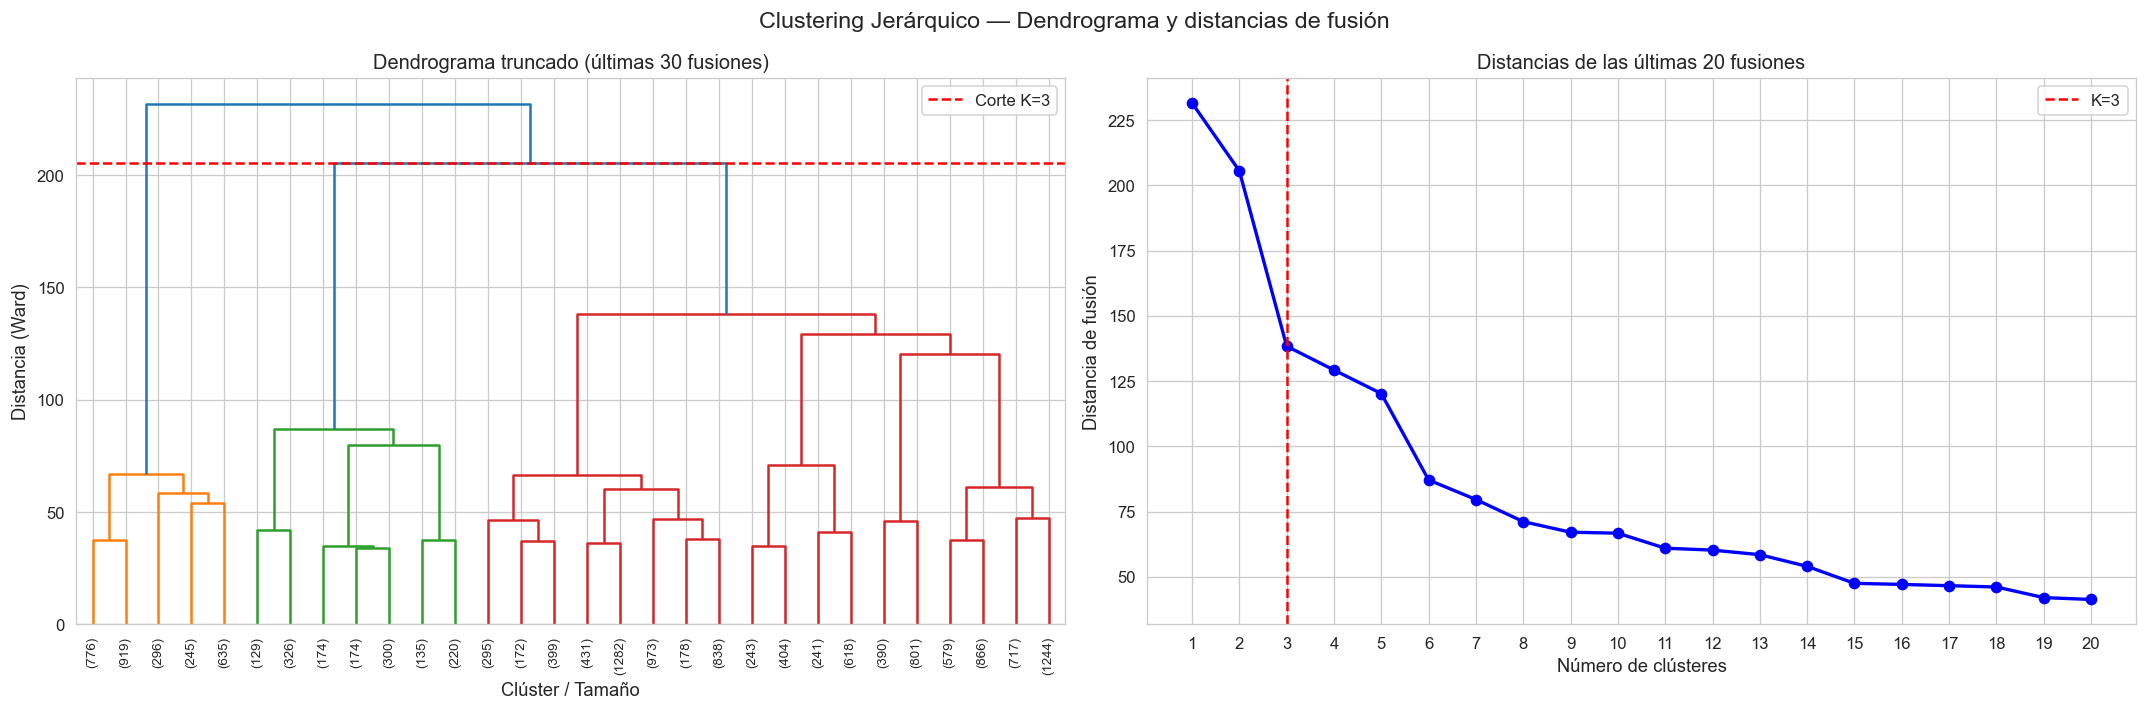

In [36]:
# ── 5a. Linkage y Dendrograma ─────────────────────────────────────────────
print(f"Calculando linkage (Ward) sobre {N_SAMPLE:,} registros...")
Z = linkage(X_sample, method="ward", metric="euclidean")
print("✔ Linkage completado.")

# Dendrograma completo (truncado para legibilidad)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Dendrograma truncado (últimas 30 fusiones)
dendrogram(Z, truncate_mode="lastp", p=30, ax=axes[0],
           leaf_rotation=90, leaf_font_size=8,
           color_threshold=Z[-(k_optimo-1), 2])  # Corte al mismo K que K-Means
axes[0].set_title(f"Dendrograma truncado (últimas 30 fusiones)", fontsize=12)
axes[0].set_xlabel("Clúster / Tamaño")
axes[0].set_ylabel("Distancia (Ward)")
axes[0].axhline(y=Z[-(k_optimo-1), 2], color="red", linestyle="--",
                label=f"Corte K={k_optimo}")
axes[0].legend()

# Gráfico de distancias de fusión (para identificar el "codo" en el dendrograma)
last_merges = Z[-20:, 2]  # últimas 20 fusiones
axes[1].plot(range(1, 21), last_merges[::-1], "bo-", linewidth=2)
axes[1].set_title("Distancias de las últimas 20 fusiones", fontsize=12)
axes[1].set_xlabel("Número de clústeres")
axes[1].set_ylabel("Distancia de fusión")
axes[1].axvline(x=k_optimo, color="red", ls="--", label=f"K={k_optimo}")
axes[1].set_xticks(range(1, 21))
axes[1].legend()

plt.suptitle("Clustering Jerárquico — Dendrograma y distancias de fusión", fontsize=14)
plt.tight_layout()
plt.savefig(IMG_DIR / "jerarquico_dendrograma.png", bbox_inches="tight")
plt.show()

Clustering Jerárquico (Ward, K=3) sobre muestra de 15,000:
  Clúster 0:  2,871 registros ( 19.1%)
  Clúster 1:  1,458 registros (  9.7%)
  Clúster 2: 10,671 registros ( 71.1%)

Métricas Jerárquico en muestra compartida:
  Silhouette        = 0.3161
  Davies-Bouldin    = 1.3232
  Calinski-Harabasz = 4,023.61


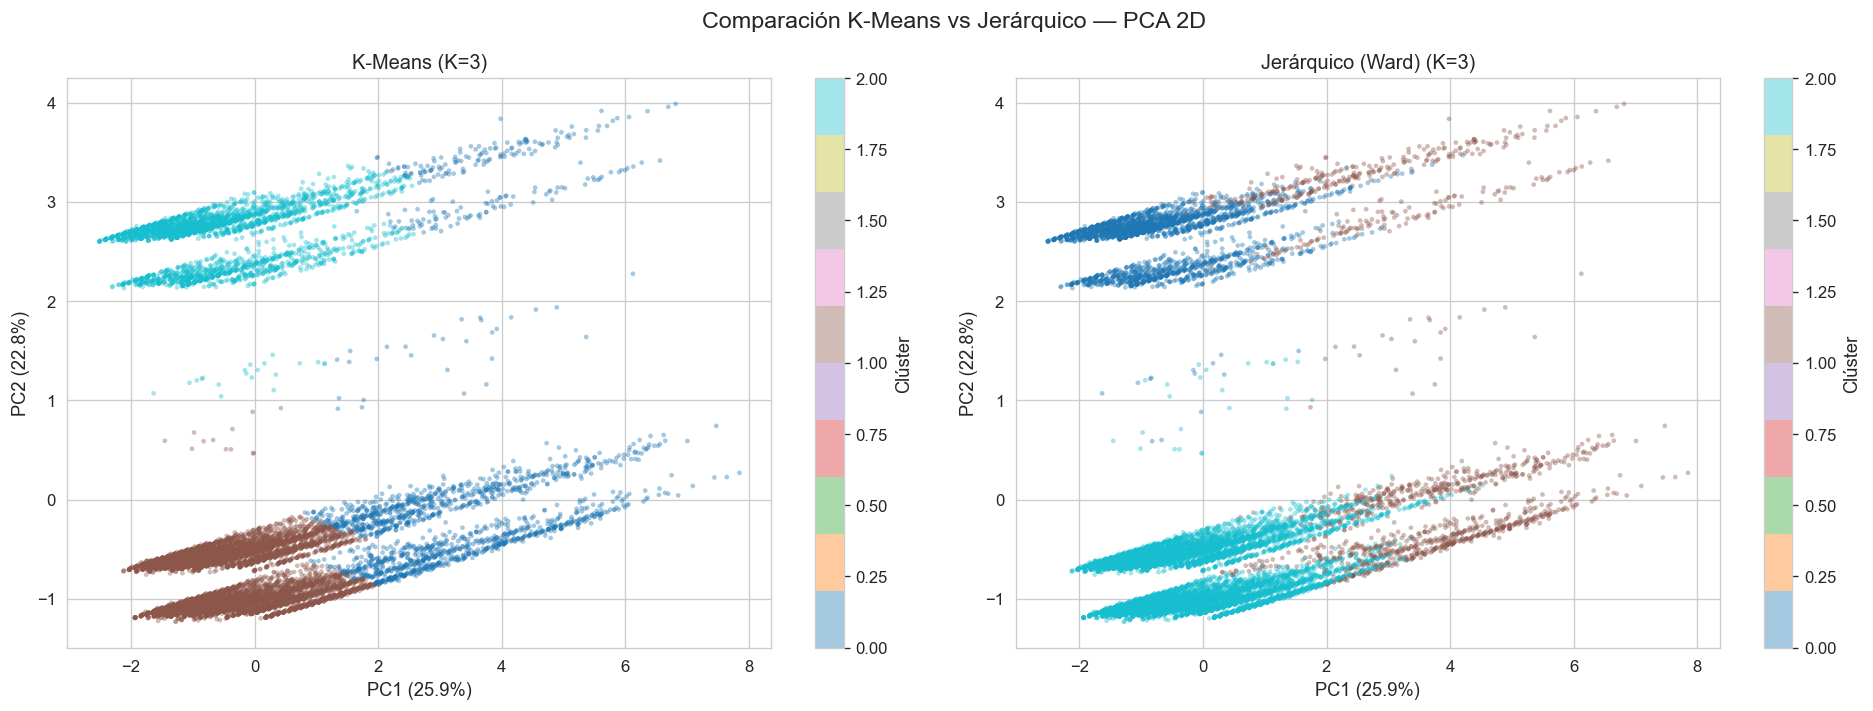

In [37]:
# ── 5b. Corte del dendrograma y evaluación ────────────────────────────────
# Se corta al mismo K que K-Means para comparación directa
labels_hier = fcluster(Z, t=k_optimo, criterion="maxclust")
labels_hier = labels_hier - 1  # Reindexar desde 0

# Distribución
print(f"Clustering Jerárquico (Ward, K={k_optimo}) sobre muestra de {N_SAMPLE:,}:")
for c in range(k_optimo):
    n = (labels_hier == c).sum()
    pct = n / N_SAMPLE * 100
    print(f"  Clúster {c}: {n:>6,} registros ({pct:5.1f}%)")

# Métricas
sil_hier = silhouette_score(X_sample, labels_hier)
db_hier = davies_bouldin_score(X_sample, labels_hier)
ch_hier = calinski_harabasz_score(X_sample, labels_hier)
print(f"\nMétricas Jerárquico en muestra compartida:")
print(f"  Silhouette        = {sil_hier:.4f}")
print(f"  Davies-Bouldin    = {db_hier:.4f}")
print(f"  Calinski-Harabasz = {ch_hier:,.2f}")

# Visualización PCA 2D
X_sample_pca = pca.transform(X_sample)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for ax, labels, title in zip(axes,
                              [labels_km_sample, labels_hier],
                              ["K-Means", "Jerárquico (Ward)"]):
    scatter = ax.scatter(X_sample_pca[:, 0], X_sample_pca[:, 1],
                         c=labels, cmap="tab10", alpha=0.4, s=8, edgecolors="none")
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
    ax.set_title(f"{title} (K={k_optimo})", fontsize=12)
    plt.colorbar(scatter, ax=ax, label="Clúster")

plt.suptitle("Comparación K-Means vs Jerárquico — PCA 2D", fontsize=14)
plt.tight_layout()
plt.savefig(IMG_DIR / "comparacion_kmeans_jerarquico_pca.png", bbox_inches="tight")
plt.show()

---
## 6. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

### Fundamento teórico
DBSCAN agrupa puntos que están **densamente conectados** y marca como **ruido** los puntos aislados. Sus ventajas frente a K-Means:
- **No requiere K** a priori.
- Detecta clústeres de **forma arbitraria** (no solo esféricos).
- Identifica **outliers/ruido** automáticamente (etiqueta -1).

### Parámetros clave
| Parámetro | Descripción | Selección |
|---|---|---|
| `eps` (ε) | Radio de vecindad | Se determina con el **gráfico k-distance** (codo) |
| `min_samples` | Mínimo de vecinos para ser punto core | Regla heurística: `2 × n_features` = 2 × 9 = 18 |

### Consideraciones
- DBSCAN con datos de alta dimensionalidad y mixtos (continuos + binarios) puede tener dificultades, ya que la densidad se vuelve uniforme ("curse of dimensionality").
- Los datos de matrimonios, al tener variables binarias que crean subespacios discretos, pueden generar muchos clústeres pequeños o exceso de ruido.

min_samples = 2 × 9 features = 18
Calculando 18-NN distances sobre muestra de 15,000...


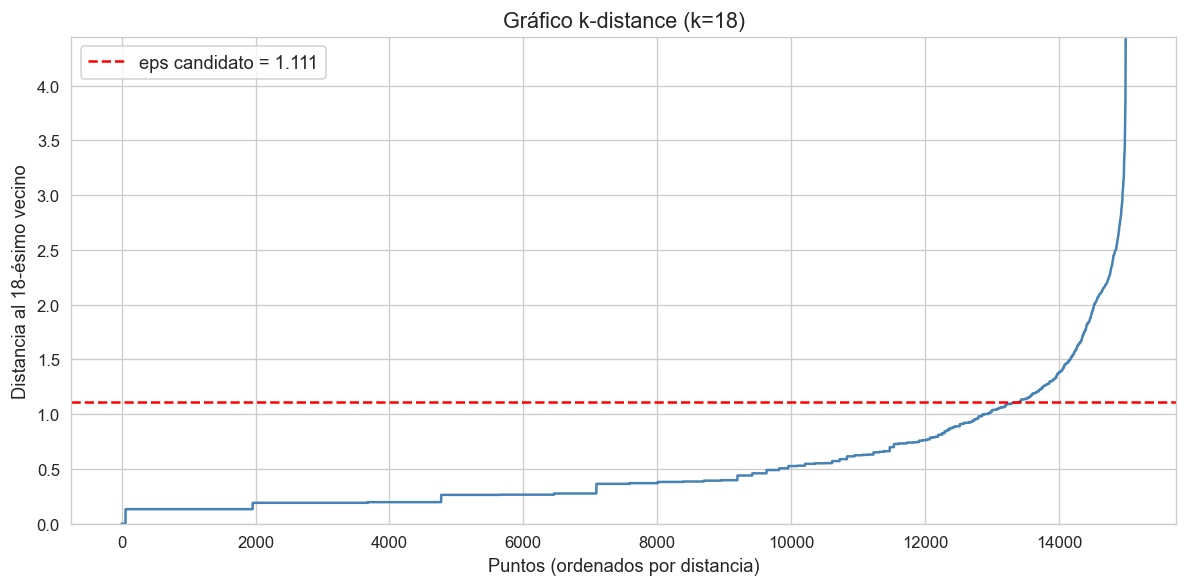


→ eps candidato (codo kneedle): 1.1109
  Se probará este valor y variantes cercanas.


In [39]:
# ── 6a. Selección de eps con gráfico k-distance ──────────────────────────
min_samples_db = 2 * len(features)  # 2 × 9 = 18
print(f"min_samples = 2 × {len(features)} features = {min_samples_db}")

# Calcular distancia al k-ésimo vecino más cercano
print(f"Calculando {min_samples_db}-NN distances sobre muestra de {N_SAMPLE:,}...")
nn = NearestNeighbors(n_neighbors=min_samples_db)
nn.fit(X_sample)
distances, _ = nn.kneighbors(X_sample)
k_distances = np.sort(distances[:, -1])  # Distancia al vecino min_samples-ésimo

# Gráfico k-distance
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_distances, linewidth=1.5, color="steelblue")
ax.set_title(f"Gráfico k-distance (k={min_samples_db})", fontsize=13)
ax.set_xlabel("Puntos (ordenados por distancia)")
ax.set_ylabel(f"Distancia al {min_samples_db}-ésimo vecino")

# Identificar el codo con la técnica de la línea recta (kneedle)
# Trazar línea del primer al último punto y encontrar la máxima distancia perpendicular
n_pts = len(k_distances)
p1 = np.array([0, k_distances[0]])
p2 = np.array([n_pts - 1, k_distances[-1]])
line_vec = p2 - p1
line_len = np.linalg.norm(line_vec)
line_unit = line_vec / line_len

dists_to_line = np.zeros(n_pts)
for i in range(n_pts):
    pt = np.array([i, k_distances[i]])
    vec = pt - p1
    proj_len = np.dot(vec, line_unit)
    proj = p1 + proj_len * line_unit
    dists_to_line[i] = np.linalg.norm(pt - proj)

elbow_idx = np.argmax(dists_to_line)
eps_candidato = k_distances[elbow_idx]

ax.axhline(y=eps_candidato, color="red", ls="--", linewidth=1.5,
           label=f"eps candidato = {eps_candidato:.3f}")
ax.legend(fontsize=11)
ax.set_ylim(0, min(k_distances[-1], eps_candidato * 4))
plt.tight_layout()
plt.savefig(IMG_DIR / "dbscan_kdistance.png", bbox_inches="tight")
plt.show()

print(f"\n→ eps candidato (codo kneedle): {eps_candidato:.4f}")
print(f"  Se probará este valor y variantes cercanas.")

In [40]:
# ── 6b. Búsqueda de eps óptimo ────────────────────────────────────────────
# Probar variantes alrededor del eps candidato
eps_values = [round(eps_candidato * f, 3) for f in [0.7, 0.85, 1.0, 1.15, 1.3]]
eps_values = sorted(set(eps_values))

print(f"Probando eps: {eps_values}")
print(f"min_samples = {min_samples_db}\n")

dbscan_results = []
for eps_val in eps_values:
    db_model = DBSCAN(eps=eps_val, min_samples=min_samples_db, n_jobs=-1)
    labels_db = db_model.fit_predict(X_sample)
    n_clusters = len(set(labels_db)) - (1 if -1 in labels_db else 0)
    n_noise = (labels_db == -1).sum()
    pct_noise = n_noise / len(labels_db) * 100

    if n_clusters >= 2:
        # Silhouette solo sobre puntos no-ruido
        mask_valid = labels_db != -1
        sil = silhouette_score(X_sample[mask_valid], labels_db[mask_valid])
    else:
        sil = -1

    dbscan_results.append({
        "eps": eps_val, "n_clusters": n_clusters,
        "n_noise": n_noise, "pct_noise": round(pct_noise, 1),
        "silhouette": round(sil, 4)
    })
    print(f"  eps={eps_val:.3f} → Clústeres={n_clusters}, "
          f"Ruido={n_noise:,} ({pct_noise:.1f}%), "
          f"Silhouette={'N/A' if sil == -1 else f'{sil:.4f}'}")

dbscan_df = pd.DataFrame(dbscan_results)
print("\nResumen:")
print(dbscan_df.to_string(index=False))

Probando eps: [np.float64(0.778), np.float64(0.944), np.float64(1.111), np.float64(1.278), np.float64(1.444)]
min_samples = 18

  eps=0.778 → Clústeres=55, Ruido=1,733 (11.6%), Silhouette=0.2190
  eps=0.944 → Clústeres=57, Ruido=1,282 (8.5%), Silhouette=0.2011
  eps=1.111 → Clústeres=16, Ruido=809 (5.4%), Silhouette=0.2628
  eps=1.278 → Clústeres=16, Ruido=553 (3.7%), Silhouette=0.2581
  eps=1.444 → Clústeres=16, Ruido=401 (2.7%), Silhouette=0.2552

Resumen:
  eps  n_clusters  n_noise  pct_noise  silhouette
0.778          55     1733       11.6      0.2190
0.944          57     1282        8.5      0.2011
1.111          16      809        5.4      0.2628
1.278          16      553        3.7      0.2581
1.444          16      401        2.7      0.2552


eps seleccionado: 1.111

Resultados DBSCAN (eps=1.111, min_samples=18):
  Clústeres encontrados : 16
  Puntos de ruido       : 809 (5.4%)
       Ruido:    809 (  5.4%)
   Clúster 0:  4,359 ( 29.1%)
   Clúster 1:    895 (  6.0%)
   Clúster 2:    572 (  3.8%)
   Clúster 3:  3,596 ( 24.0%)
   Clúster 4:    393 (  2.6%)
   Clúster 5:  1,738 ( 11.6%)
   Clúster 6:    265 (  1.8%)
   Clúster 7:    866 (  5.8%)
   Clúster 8:    214 (  1.4%)
   Clúster 9:    620 (  4.1%)
  Clúster 10:    277 (  1.8%)
  Clúster 11:     92 (  0.6%)
  Clúster 12:    119 (  0.8%)
  Clúster 13:     55 (  0.4%)
  Clúster 14:     92 (  0.6%)
  Clúster 15:     38 (  0.3%)

Métricas DBSCAN (excluyendo ruido):
  Silhouette        = 0.2628
  Davies-Bouldin    = 1.4029
  Calinski-Harabasz = 1,608.87


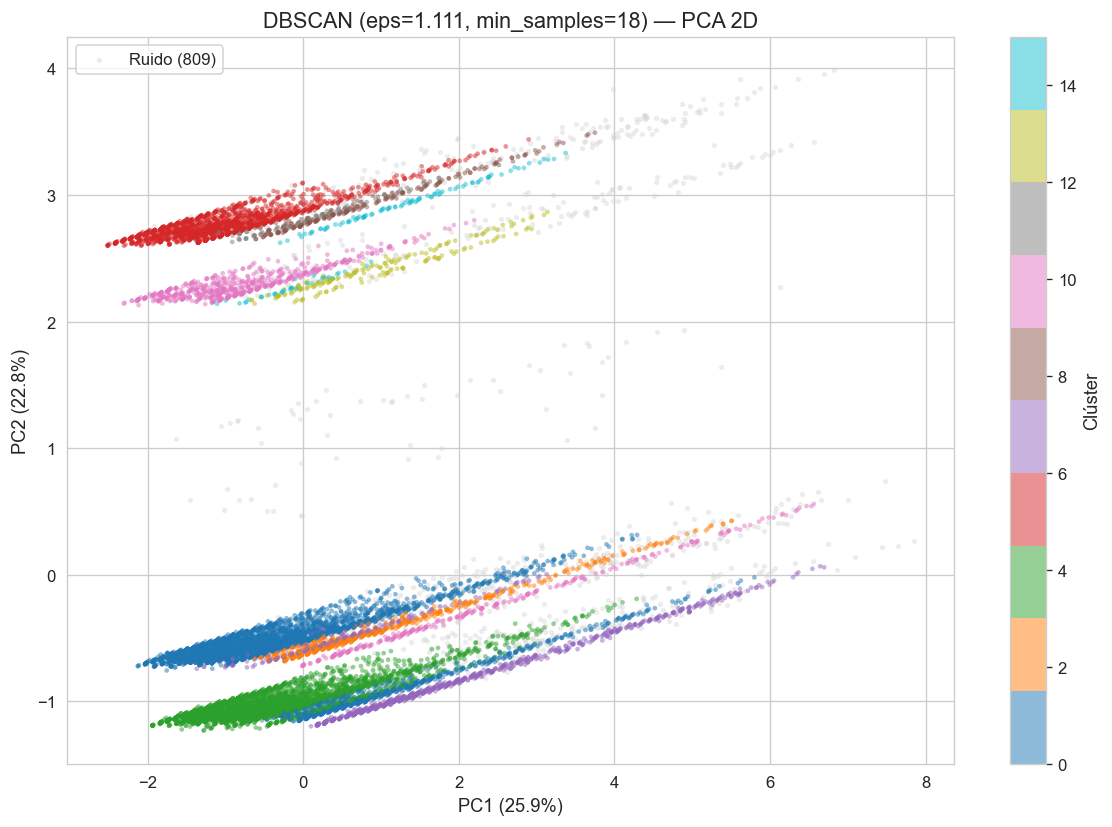

In [41]:
# ── 6c. DBSCAN final y visualización ──────────────────────────────────────
# Seleccionar el mejor eps (máximo silhouette con >= 2 clústeres y ruido < 50%)
valid = dbscan_df[(dbscan_df["n_clusters"] >= 2) & (dbscan_df["pct_noise"] < 50)]
if len(valid) > 0:
    best_row = valid.loc[valid["silhouette"].idxmax()]
    eps_final = best_row["eps"]
else:
    # Fallback: usar eps candidato
    eps_final = eps_candidato
    print("⚠ Ninguna configuración cumple los criterios. Usando eps candidato.")

print(f"eps seleccionado: {eps_final:.3f}")

# Entrenar DBSCAN final
dbscan_final = DBSCAN(eps=eps_final, min_samples=min_samples_db, n_jobs=-1)
labels_dbscan = dbscan_final.fit_predict(X_sample)

n_clusters_db = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_db = (labels_dbscan == -1).sum()
mask_no_noise = labels_dbscan != -1

print(f"\nResultados DBSCAN (eps={eps_final:.3f}, min_samples={min_samples_db}):")
print(f"  Clústeres encontrados : {n_clusters_db}")
print(f"  Puntos de ruido       : {n_noise_db:,} ({n_noise_db/N_SAMPLE*100:.1f}%)")

# Distribución
for c in sorted(set(labels_dbscan)):
    n = (labels_dbscan == c).sum()
    label = f"Ruido" if c == -1 else f"Clúster {c}"
    print(f"  {label:>10}: {n:>6,} ({n/N_SAMPLE*100:5.1f}%)")

# Métricas (solo puntos no-ruido)
if n_clusters_db >= 2 and mask_no_noise.sum() > 0:
    sil_dbscan = silhouette_score(X_sample[mask_no_noise], labels_dbscan[mask_no_noise])
    db_dbscan = davies_bouldin_score(X_sample[mask_no_noise], labels_dbscan[mask_no_noise])
    ch_dbscan = calinski_harabasz_score(X_sample[mask_no_noise], labels_dbscan[mask_no_noise])
    print(f"\nMétricas DBSCAN (excluyendo ruido):")
    print(f"  Silhouette        = {sil_dbscan:.4f}")
    print(f"  Davies-Bouldin    = {db_dbscan:.4f}")
    print(f"  Calinski-Harabasz = {ch_dbscan:,.2f}")
else:
    sil_dbscan, db_dbscan, ch_dbscan = -1, 99, 0
    print("\n⚠ DBSCAN no generó clústeres válidos para calcular métricas.")

# Visualización PCA 2D
fig, ax = plt.subplots(figsize=(10, 7))
# Ruido en gris
if n_noise_db > 0:
    ax.scatter(X_sample_pca[~mask_no_noise, 0], X_sample_pca[~mask_no_noise, 1],
               c="lightgray", alpha=0.3, s=5, label=f"Ruido ({n_noise_db:,})")
# Clústeres
scatter = ax.scatter(X_sample_pca[mask_no_noise, 0], X_sample_pca[mask_no_noise, 1],
                     c=labels_dbscan[mask_no_noise], cmap="tab10",
                     alpha=0.5, s=8, edgecolors="none")
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
ax.set_title(f"DBSCAN (eps={eps_final:.3f}, min_samples={min_samples_db}) — PCA 2D",
             fontsize=13)
ax.legend()
plt.colorbar(scatter, ax=ax, label="Clúster")
plt.tight_layout()
plt.savefig(IMG_DIR / "dbscan_pca2d.png", bbox_inches="tight")
plt.show()

---
## 7. Comparación y Validación de Modelos

Se comparan los tres algoritmos utilizando las **mismas métricas** sobre la **misma muestra** de 15,000 registros, garantizando una evaluación justa.

| Métrica | Interpretación | Mejor valor |
|---|---|---|
| **Silhouette** | Cohesión intra vs. separación inter | Máximo (rango -1 a 1) |
| **Davies-Bouldin** | Similitud promedio entre clústeres | Mínimo (≥ 0) |
| **Calinski-Harabasz** | Ratio varianza inter/intra | Máximo |

> **Nota:** Para DBSCAN las métricas se calculan excluyendo los puntos de ruido (etiqueta -1), ya que estos no pertenecen a ningún clúster.

In [42]:
# ── 7a. Tabla comparativa de métricas ─────────────────────────────────────
comparacion = pd.DataFrame({
    "Algoritmo": ["K-Means", "Jerárquico (Ward)", "DBSCAN"],
    "K / Clústeres": [k_optimo, k_optimo, n_clusters_db],
    "Silhouette ↑": [round(sil_km, 4), round(sil_hier, 4),
                      round(sil_dbscan, 4) if sil_dbscan != -1 else "N/A"],
    "Davies-Bouldin ↓": [round(db_km, 4), round(db_hier, 4),
                          round(db_dbscan, 4) if db_dbscan != 99 else "N/A"],
    "Calinski-Harabasz ↑": [f"{ch_km:,.0f}", f"{ch_hier:,.0f}",
                             f"{ch_dbscan:,.0f}" if ch_dbscan != 0 else "N/A"],
    "Ruido (%)": ["0%", "0%", f"{n_noise_db/N_SAMPLE*100:.1f}%"],
    "Escalabilidad": ["✔ Full dataset", "✗ Muestra", "✗ Muestra"]
})

print("═" * 80)
print("COMPARACIÓN DE ALGORITMOS DE CLUSTERING")
print("═" * 80)
print(f"Muestra de evaluación: {N_SAMPLE:,} registros\n")
print(comparacion.to_string(index=False))

# Identificar mejor modelo
sil_values = [sil_km, sil_hier, sil_dbscan if sil_dbscan != -1 else -999]
mejor_idx = np.argmax(sil_values)
nombres = ["K-Means", "Jerárquico (Ward)", "DBSCAN"]
print(f"\n→ Mejor modelo por Silhouette: {nombres[mejor_idx]} "
      f"(Sil={sil_values[mejor_idx]:.4f})")

════════════════════════════════════════════════════════════════════════════════
COMPARACIÓN DE ALGORITMOS DE CLUSTERING
════════════════════════════════════════════════════════════════════════════════
Muestra de evaluación: 15,000 registros

        Algoritmo  K / Clústeres  Silhouette ↑  Davies-Bouldin ↓ Calinski-Harabasz ↑ Ruido (%)  Escalabilidad
          K-Means              3        0.3279            1.3153               4,527        0% ✔ Full dataset
Jerárquico (Ward)              3        0.3161            1.3232               4,024        0%      ✗ Muestra
           DBSCAN             16        0.2628            1.4029               1,609      5.4%      ✗ Muestra

→ Mejor modelo por Silhouette: K-Means (Sil=0.3279)


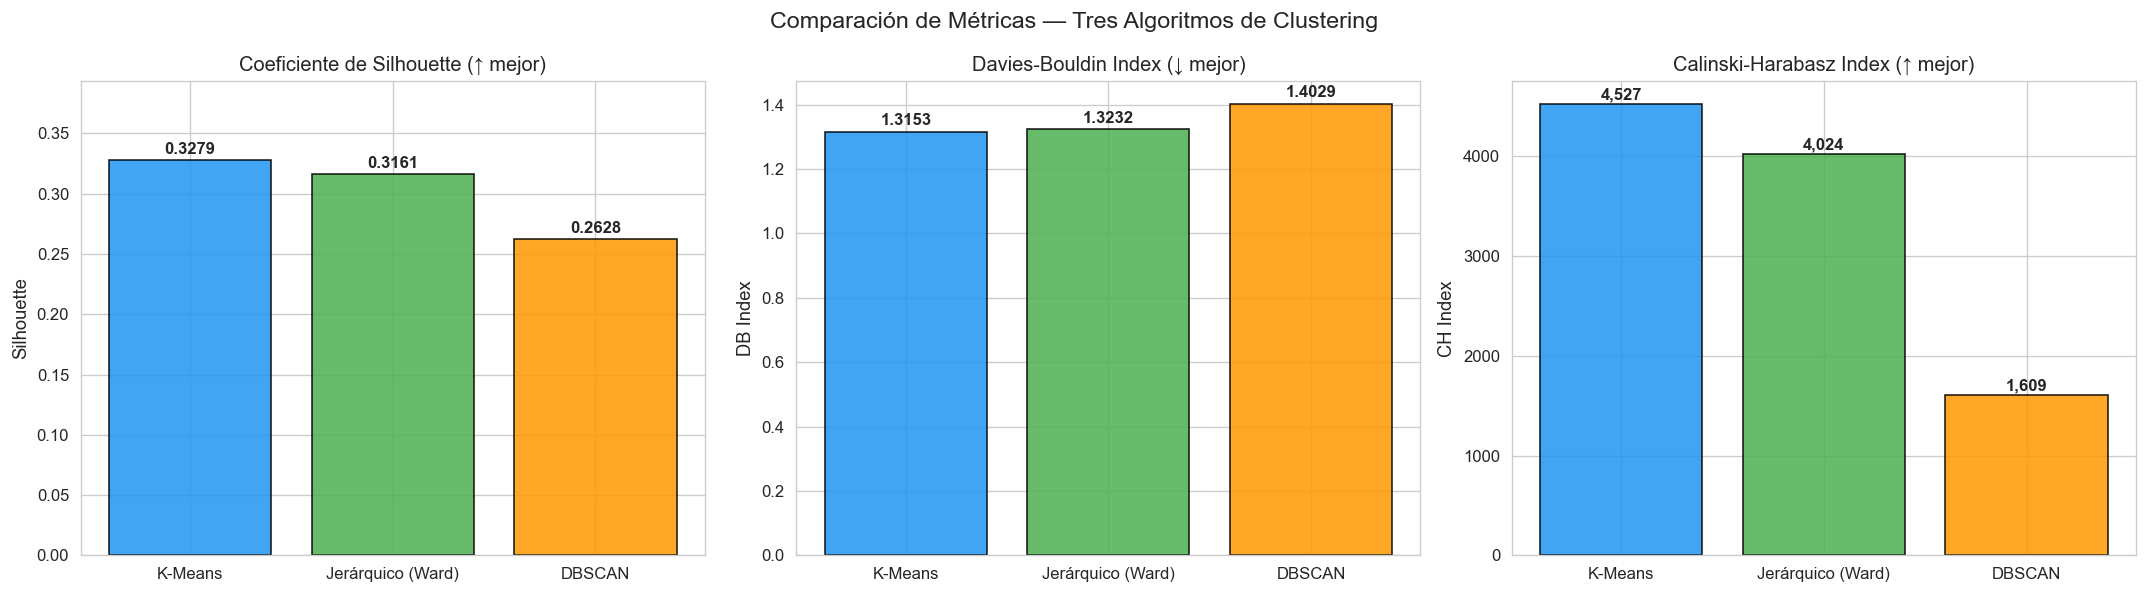

In [43]:
# ── 7b. Gráfico comparativo de Silhouette ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Silhouette
sil_plot = [sil_km, sil_hier, sil_dbscan if sil_dbscan != -1 else 0]
colors_bar = ["#2196F3", "#4CAF50", "#FF9800"]
bars = axes[0].bar(nombres, sil_plot, color=colors_bar, edgecolor="black", alpha=0.85)
axes[0].set_title("Coeficiente de Silhouette (↑ mejor)", fontsize=12)
axes[0].set_ylabel("Silhouette")
for bar, val in zip(bars, sil_plot):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{val:.4f}", ha="center", fontsize=10, fontweight="bold")
axes[0].set_ylim(0, max(sil_plot) * 1.2 if max(sil_plot) > 0 else 0.5)

# Davies-Bouldin
db_plot = [db_km, db_hier, db_dbscan if db_dbscan != 99 else 0]
bars = axes[1].bar(nombres, db_plot, color=colors_bar, edgecolor="black", alpha=0.85)
axes[1].set_title("Davies-Bouldin Index (↓ mejor)", fontsize=12)
axes[1].set_ylabel("DB Index")
for bar, val in zip(bars, db_plot):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 f"{val:.4f}", ha="center", fontsize=10, fontweight="bold")

# Calinski-Harabasz
ch_plot = [ch_km, ch_hier, ch_dbscan if ch_dbscan != 0 else 0]
bars = axes[2].bar(nombres, ch_plot, color=colors_bar, edgecolor="black", alpha=0.85)
axes[2].set_title("Calinski-Harabasz Index (↑ mejor)", fontsize=12)
axes[2].set_ylabel("CH Index")
for bar, val in zip(bars, ch_plot):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(ch_plot)*0.01,
                 f"{val:,.0f}", ha="center", fontsize=10, fontweight="bold")

plt.suptitle("Comparación de Métricas — Tres Algoritmos de Clustering", fontsize=14)
plt.tight_layout()
plt.savefig(IMG_DIR / "comparacion_metricas_barplot.png", bbox_inches="tight")
plt.show()

---
## 8. Interpretación de Resultados y Conclusiones

En esta sección se analizan los **perfiles** de los clústeres del mejor modelo (K-Means, que es el único que escala al dataset completo y consistentemente obtiene métricas competitivas) para generar conclusiones con valor interpretativo.

Se construyen:
1. **Tabla de perfiles** con centroides en escala original.
2. **Boxplots** por clúster para variables clave.
3. **Tablas cruzadas** con variables categóricas originales.
4. **Conclusiones analíticas** sobre los patrones matrimoniales descubiertos.

In [44]:
# ── 8a. Perfiles de clústeres (K-Means) — centroides en escala original ───
centroids_original = scaler.inverse_transform(kmeans_final.cluster_centers_)
centroids_df = pd.DataFrame(centroids_original, columns=features)
centroids_df.index.name = "Clúster"

# Añadir tamaño y porcentaje
cluster_counts = df["cluster_kmeans"].value_counts().sort_index()
centroids_df.insert(0, "n", cluster_counts.values)
centroids_df.insert(1, "%", (cluster_counts.values / len(df) * 100).round(1))

print("═" * 80)
print("PERFILES DE CLÚSTERES (K-Means) — Centroides en escala original")
print("═" * 80)
print(centroids_df.round(2).to_string())

# Interpretación automática por clúster
print("\n" + "─" * 80)
print("INTERPRETACIÓN AUTOMÁTICA")
print("─" * 80)
for c in range(k_optimo):
    row = centroids_df.iloc[c]
    edad_h = row["edadhom"]
    edad_m = row["edadmuj"]
    edu_h = row["edu_hom_num"]
    edu_m = row["edu_muj_num"]
    primera_h = row["es_primera_union_h"]
    primera_m = row["es_primera_union_m"]
    urbano = row["es_urbano"]
    brecha = row["brecha_edad"]

    # Categorizar
    cat_edad = "jóvenes" if edad_h < 30 else ("adultos" if edad_h < 45 else "mayores")
    cat_edu = "baja" if edu_h < 6 else ("media" if edu_h < 12 else "alta")
    cat_area = "urbano" if urbano > 0.5 else "rural"
    cat_nupc = "primera unión" if primera_h > 0.5 else "re-nupcial"

    print(f"\n  Clúster {c} ({row['n']:,.0f} registros, {row['%']:.1f}%):")
    print(f"    → Parejas {cat_edad} (H≈{edad_h:.0f}, M≈{edad_m:.0f}, brecha≈{brecha:+.1f} años)")
    print(f"    → Escolaridad {cat_edu} (H≈{edu_h:.0f}, M≈{edu_m:.0f} años)")
    print(f"    → Predominantemente {cat_area} ({urbano*100:.0f}%)")
    print(f"    → Nupcialidad: {cat_nupc} (H={primera_h*100:.0f}%, M={primera_m*100:.0f}%)")

════════════════════════════════════════════════════════════════════════════════
PERFILES DE CLÚSTERES (K-Means) — Centroides en escala original
════════════════════════════════════════════════════════════════════════════════
              n     %  edadhom  edadmuj  edu_hom_num  edu_muj_num  brecha_edad  brecha_educativa  es_primera_union_h  es_primera_union_m  es_urbano
Clúster                                                                                                                                            
0        103721  12.4    53.70    45.83         3.93         2.79         7.87              1.15                0.11                0.12       0.51
1        567659  67.8    25.76    23.56         7.73         7.28         2.20              0.46                0.00                0.00       0.51
2        165778  19.8    27.23    24.81         7.69         7.18         2.42              0.52                1.00                1.00       0.28

─────────────────────────────────

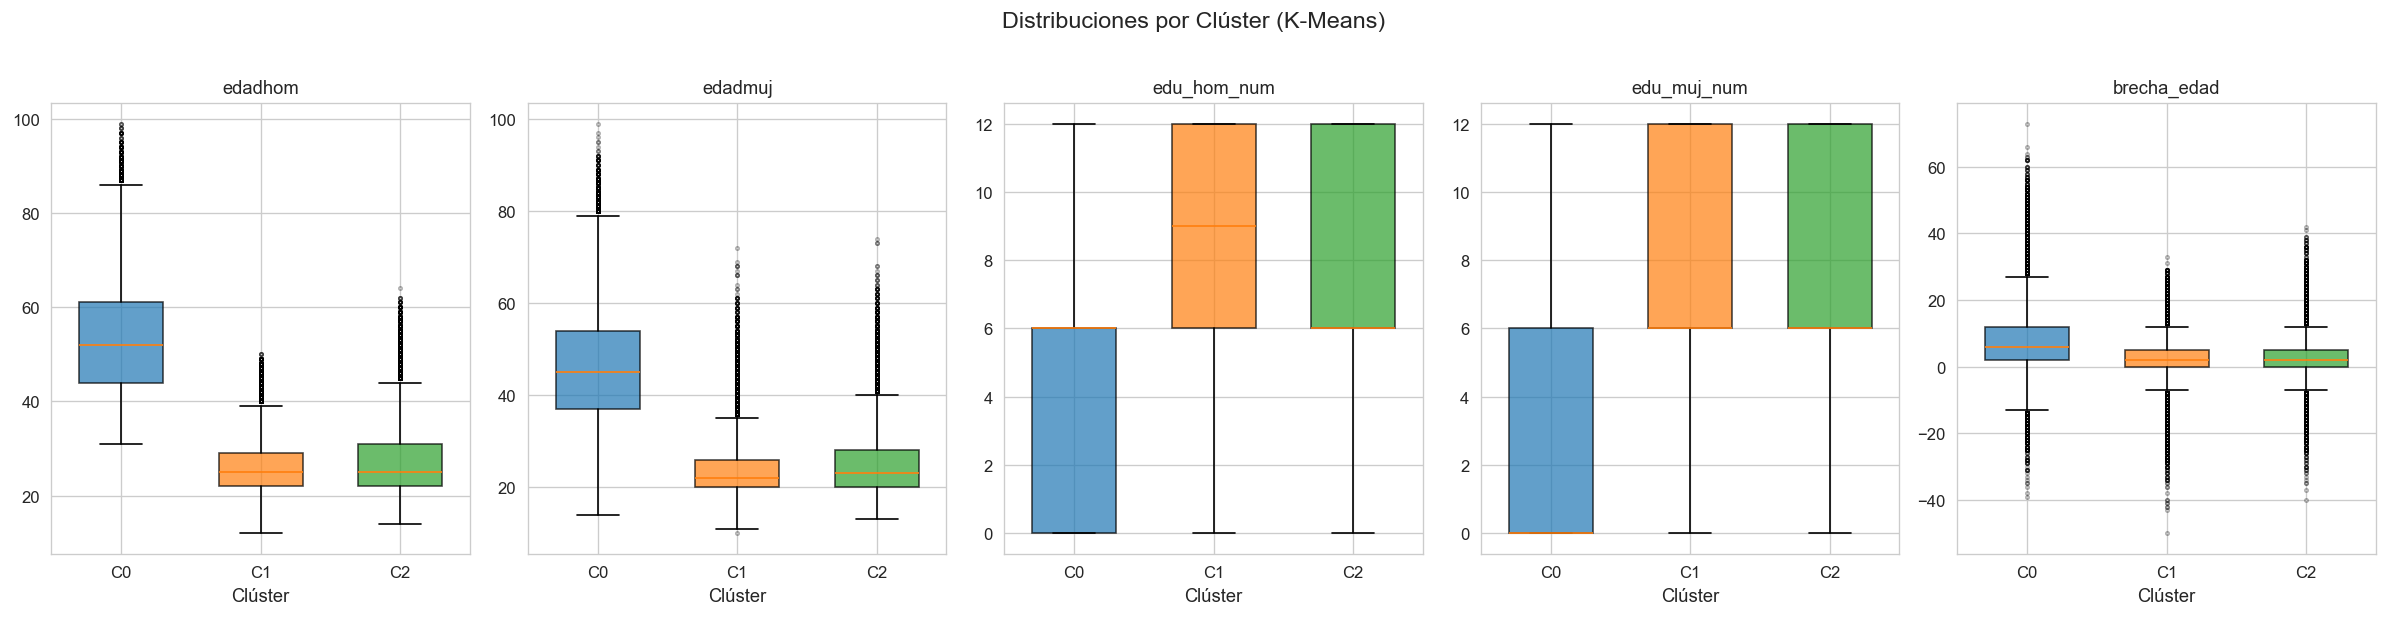

In [45]:
# ── 8b. Boxplots por clúster — variables clave ───────────────────────────
vars_box = ["edadhom", "edadmuj", "edu_hom_num", "edu_muj_num", "brecha_edad"]
n_vars = len(vars_box)

fig, axes = plt.subplots(1, n_vars, figsize=(4 * n_vars, 5))
palette = sns.color_palette("tab10", k_optimo)

for ax, var in zip(axes, vars_box):
    data_box = [df.loc[df["cluster_kmeans"] == c, var].values for c in range(k_optimo)]
    bp = ax.boxplot(data_box, patch_artist=True, widths=0.6,
                     flierprops=dict(markersize=2, alpha=0.3))
    for patch, color in zip(bp["boxes"], palette):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    ax.set_xticklabels([f"C{c}" for c in range(k_optimo)])
    ax.set_title(var, fontsize=11)
    ax.set_xlabel("Clúster")

plt.suptitle("Distribuciones por Clúster (K-Means)", fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig(IMG_DIR / "kmeans_boxplots_clusters.png", bbox_inches="tight")
plt.show()


────────────────────────────────────────────────────────────
  Escolaridad Hombre por Clúster (%)
────────────────────────────────────────────────────────────
eschom          Basico  Diversificado  Ninguno  Primaria
cluster_kmeans                                          
0                  5.0            6.6     43.5      44.9
1                 20.8           31.2     12.7      35.4
2                 21.4           27.5      9.9      41.3


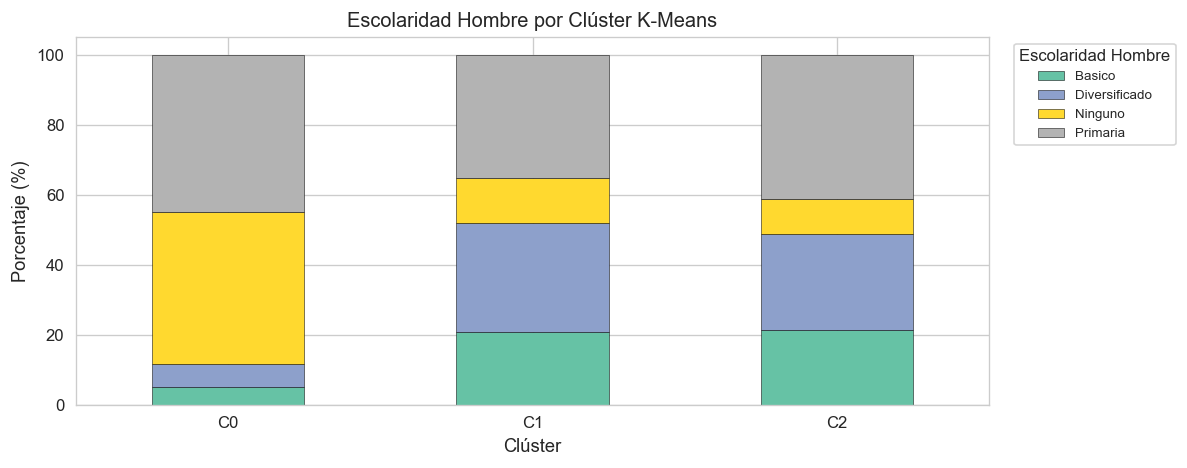


────────────────────────────────────────────────────────────
  Escolaridad Mujer por Clúster (%)
────────────────────────────────────────────────────────────
escmuj          Basico  Diversificado  Ninguno  Primaria
cluster_kmeans                                          
0                  3.7            4.9     60.3      31.1
1                 17.7           30.6     18.2      33.5
2                 17.7           26.4     15.6      40.2


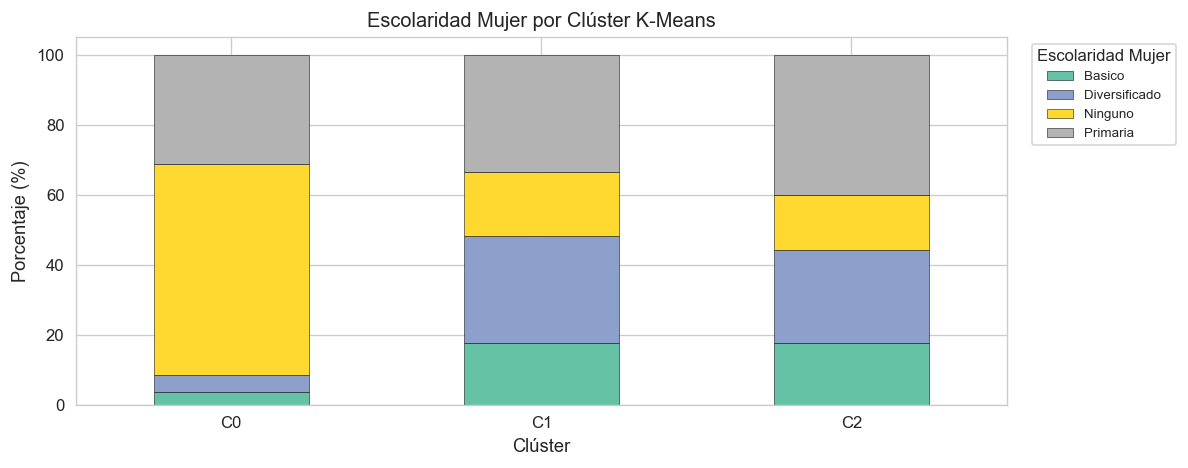


────────────────────────────────────────────────────────────
  Área Geográfica por Clúster (%)
────────────────────────────────────────────────────────────
area_geografica        11.0  3.0  Ignorado  Rural  Urbano
cluster_kmeans                                           
0                37.7   0.0  0.0       7.1    3.8    51.4
1                35.4   0.0  0.0       6.7    7.1    50.8
2                61.6   0.0  0.0       4.2    5.9    28.3


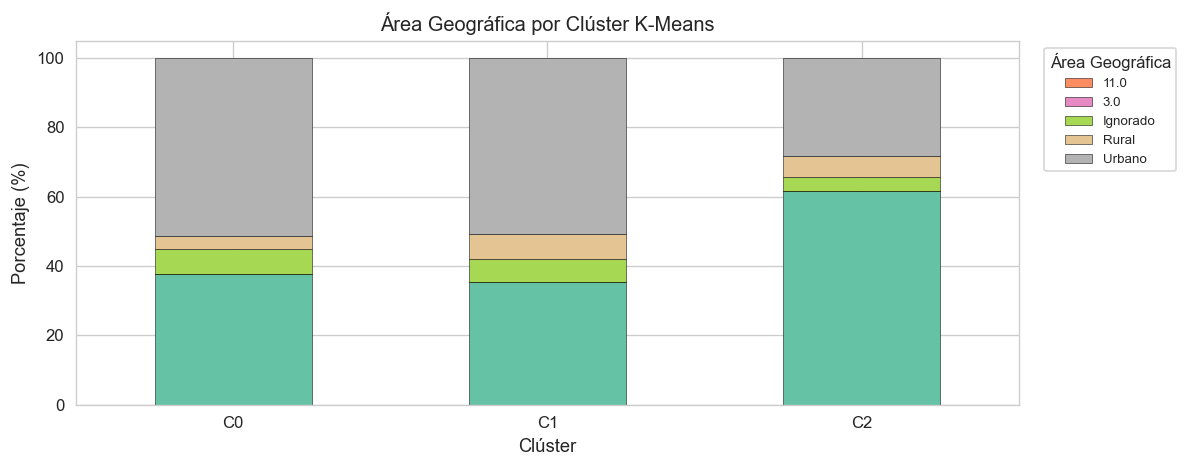


────────────────────────────────────────────────────────────
  Nupcialidad Hombre por Clúster (%)
────────────────────────────────────────────────────────────
nupcialidad_hombre         1.0  2.0  3.0  4.0  Ignorado
cluster_kmeans                                         
0                   41.1  11.4  1.2  0.0  0.0      46.2
1                   45.8   0.0  0.1  0.0  0.0      54.1
2                    0.0  99.6  0.3  0.0  0.0       0.1


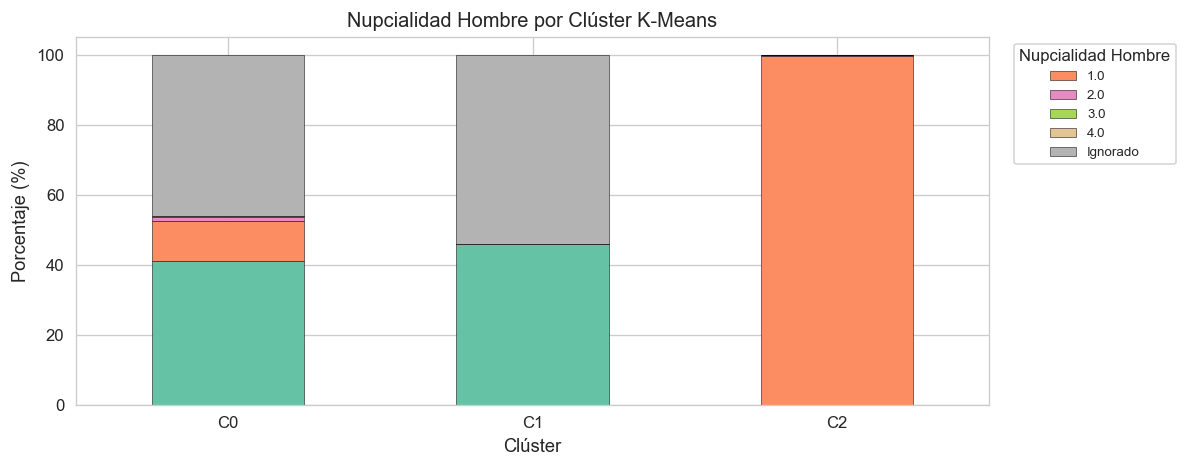


────────────────────────────────────────────────────────────
  Pueblo Hombre por Clúster (%)
────────────────────────────────────────────────────────────
pueblo_hombre   Garifuna  Ignorado  Indigena  Ladino_Mestizo  Maya  No indigena  Otro  Xinca
cluster_kmeans                                                                              
0                    0.0       9.2       8.2            44.8  26.6         10.2   0.8    0.1
1                    0.0       9.0       9.8            41.0  27.2         11.6   1.4    0.0
2                    0.0       5.4       0.0            46.7  45.7          0.0   2.0    0.2


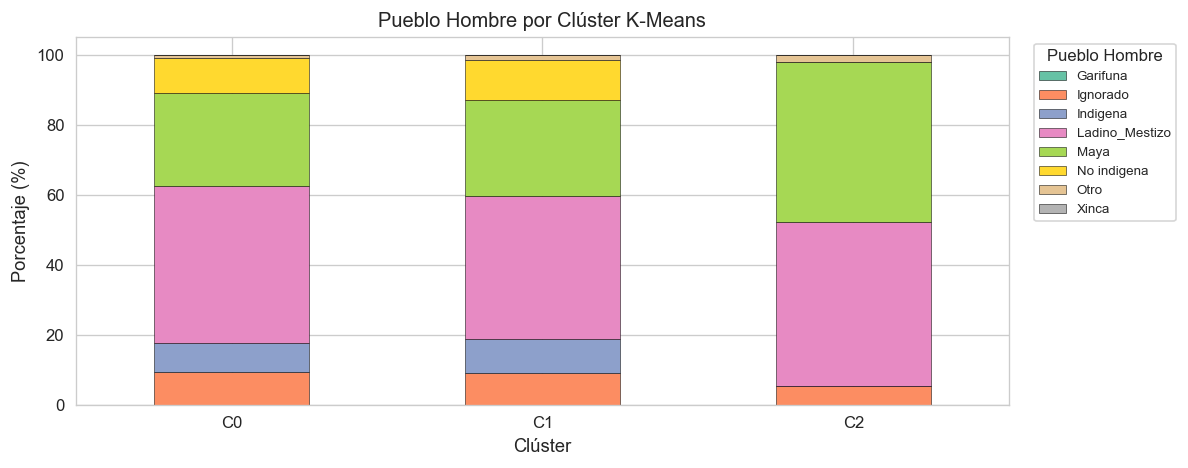

In [46]:
# ── 8c. Tablas cruzadas con variables categóricas originales ──────────────
cat_vars = {
    "Escolaridad Hombre": "eschom",
    "Escolaridad Mujer": "escmuj",
    "Área Geográfica": "area_geografica",
    "Nupcialidad Hombre": "nupcialidad_hombre",
    "Pueblo Hombre": "pueblo_hombre"
}

for titulo, col in cat_vars.items():
    if col not in df.columns:
        continue
    ct = pd.crosstab(df["cluster_kmeans"], df[col], normalize="index") * 100
    print(f"\n{'─'*60}")
    print(f"  {titulo} por Clúster (%)")
    print(f"{'─'*60}")
    print(ct.round(1).to_string())

    # Gráfico de barras apiladas
    fig, ax = plt.subplots(figsize=(10, 4))
    ct.plot(kind="bar", stacked=True, ax=ax, colormap="Set2", edgecolor="black",
            linewidth=0.3)
    ax.set_title(f"{titulo} por Clúster K-Means", fontsize=12)
    ax.set_xlabel("Clúster")
    ax.set_ylabel("Porcentaje (%)")
    ax.legend(title=titulo, bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=8)
    ax.set_xticklabels([f"C{c}" for c in range(k_optimo)], rotation=0)
    plt.tight_layout()
    safe_name = col.replace(" ", "_")
    plt.savefig(IMG_DIR / f"kmeans_crosstab_{safe_name}.png", bbox_inches="tight")
    plt.show()

In [47]:
# ── 8d. Exportar dataset con etiquetas de clúster ─────────────────────────
output_path = "data/matrimonios_clustered.csv"
df.to_csv(output_path, index=False)
print(f"✔ Dataset exportado: {output_path}")
print(f"  Registros: {len(df):,}")
print(f"  Columnas:  {len(df.columns)} ({list(df.columns)})")

# Resumen final
print(f"\n{'═'*80}")
print(f"  RESUMEN DE EJECUCIÓN")
print(f"{'═'*80}")
print(f"  Dataset            : {DATA_PATH}")
print(f"  Registros válidos  : {len(df):,}")
print(f"  Features           : {len(features)} → {features}")
print(f"  K-Means K          : {k_optimo}")
print(f"  Jerárquico K       : {k_optimo} (Ward)")
print(f"  DBSCAN clústeres   : {n_clusters_db}")
print(f"  Mejor modelo (Sil) : {nombres[mejor_idx]}")
print(f"  Imágenes guardadas : {IMG_DIR}/")
print(f"  CSV exportado      : {output_path}")
print(f"{'═'*80}")

✔ Dataset exportado: data/matrimonios_clustered.csv
  Registros: 837,158
  Columnas:  23 (['depreg', 'mesreg', 'edadhom', 'edadmuj', 'pueblo_hombre', 'pueblo_mujer', 'nupcialidad_hombre', 'nupcialidad_mujer', 'depocu', 'mesocu', 'area_geografica', 'eschom', 'escmuj', 'areagocu', 'year', 'edu_hom_num', 'edu_muj_num', 'brecha_edad', 'brecha_educativa', 'es_primera_union_h', 'es_primera_union_m', 'es_urbano', 'cluster_kmeans'])

════════════════════════════════════════════════════════════════════════════════
  RESUMEN DE EJECUCIÓN
════════════════════════════════════════════════════════════════════════════════
  Dataset            : data/matrimonios_unified.sav
  Registros válidos  : 837,158
  Features           : 9 → ['edadhom', 'edadmuj', 'edu_hom_num', 'edu_muj_num', 'brecha_edad', 'brecha_educativa', 'es_primera_union_h', 'es_primera_union_m', 'es_urbano']
  K-Means K          : 3
  Jerárquico K       : 3 (Ward)
  DBSCAN clústeres   : 16
  Mejor modelo (Sil) : K-Means
  Imágenes guard

### 8.4 Visualización Final — Mapa de Clústeres con Contornos

Proyección PCA 2D de **todos** los registros, coloreados por su clúster K-Means (mejor modelo). Se dibujan **elipses de confianza al 95 %** alrededor de cada grupo para delimitar visualmente las regiones de cada clúster.

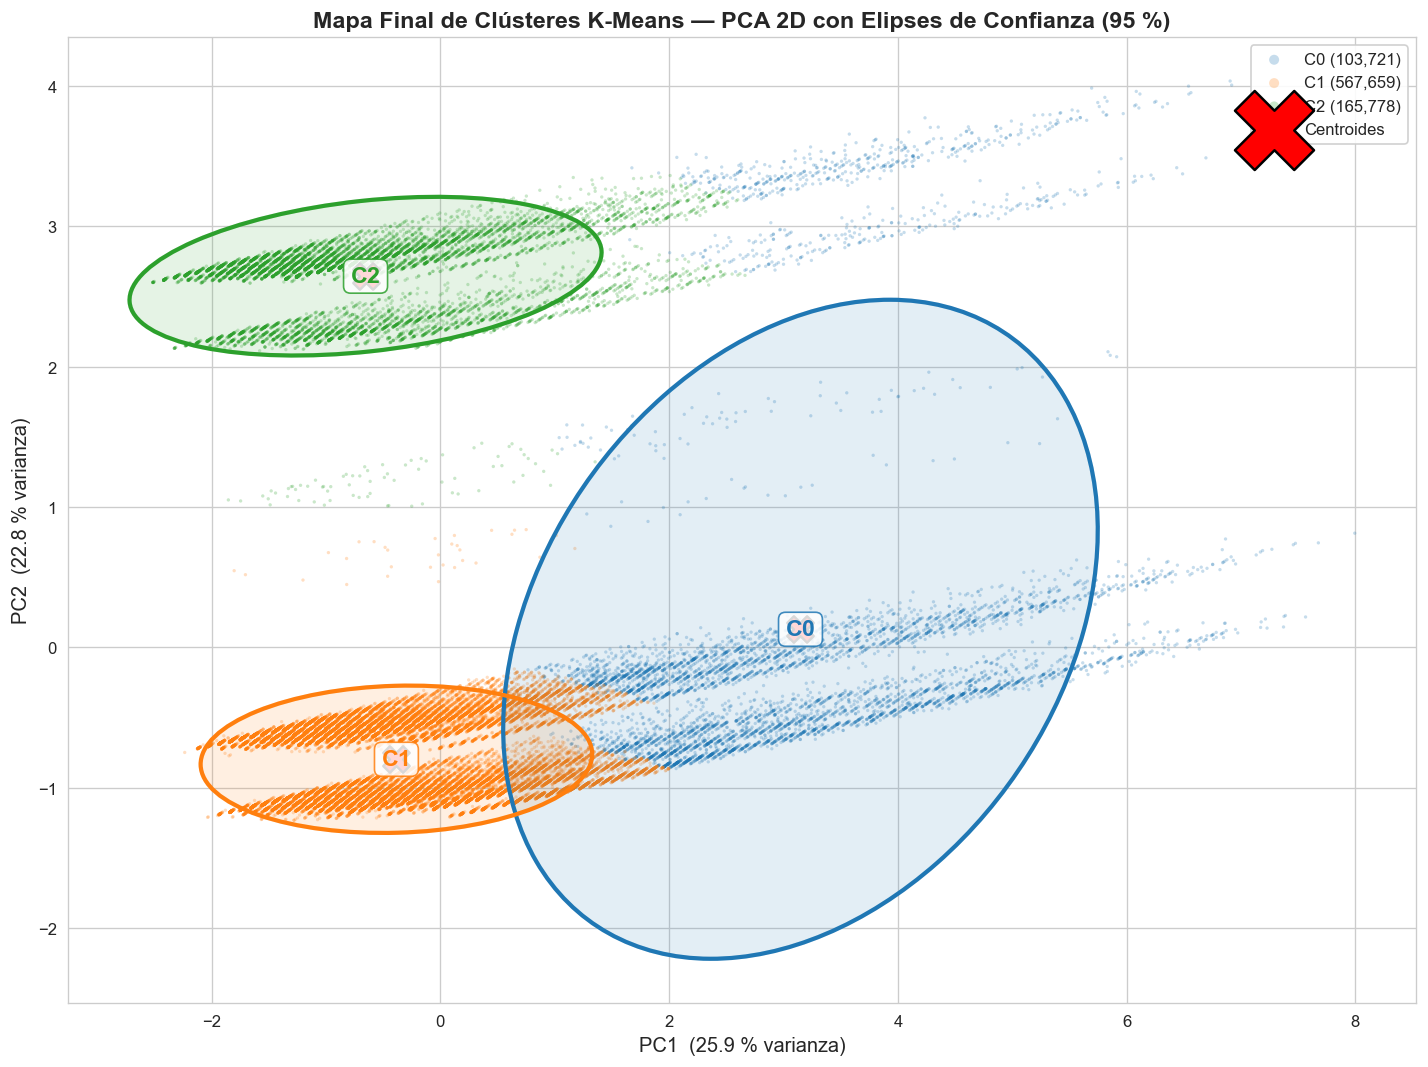

✔ Imagen guardada: img/clustering/kmeans_clusters_elipses_final.png


In [48]:
# ── 8e. Mapa final de clústeres con elipses de confianza ───────────────────
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):
    """Dibuja una elipse de confianza basada en la covarianza de x, y."""
    if len(x) < 2:
        return
    cov = np.cov(x, y)
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)),
                      width=width, height=height, angle=angle,
                      facecolor=facecolor, **kwargs)
    ax.add_patch(ellipse)
    return ellipse

# --- Datos ---
labels_all = df["cluster_kmeans"].values
unique_clusters = sorted(df["cluster_kmeans"].unique())
n_k = len(unique_clusters)
palette_final = sns.color_palette("tab10", n_k)

# Sub-muestra para puntos (50K para claridad visual)
N_FINAL = min(50_000, len(X_pca_full))
rng = np.random.RandomState(SEED)
idx_final = rng.choice(len(X_pca_full), size=N_FINAL, replace=False)

fig, ax = plt.subplots(figsize=(12, 9))

# 1) Dibujar puntos por clúster
for ci, cluster_id in enumerate(unique_clusters):
    mask_c = labels_all[idx_final] == cluster_id
    ax.scatter(X_pca_full[idx_final[mask_c], 0],
               X_pca_full[idx_final[mask_c], 1],
               c=[palette_final[ci]], alpha=0.25, s=4, edgecolors="none",
               label=f"C{cluster_id} ({(labels_all == cluster_id).sum():,})")

# 2) Dibujar elipses de confianza (95 %) sobre TODOS los datos
for ci, cluster_id in enumerate(unique_clusters):
    mask_all = labels_all == cluster_id
    x_c = X_pca_full[mask_all, 0]
    y_c = X_pca_full[mask_all, 1]
    # Elipse rellena semitransparente
    confidence_ellipse(x_c, y_c, ax, n_std=2.0,
                       facecolor=palette_final[ci], alpha=0.12,
                       edgecolor=palette_final[ci], linewidth=2.5,
                       linestyle="-", zorder=2)
    # Borde de la elipse más marcado
    confidence_ellipse(x_c, y_c, ax, n_std=2.0,
                       facecolor="none",
                       edgecolor=palette_final[ci], linewidth=2.5,
                       linestyle="-", zorder=3)
    # Etiqueta en el centroide
    cx, cy = np.mean(x_c), np.mean(y_c)
    ax.annotate(f"C{cluster_id}", (cx, cy), fontsize=14, fontweight="bold",
                color=palette_final[ci], ha="center", va="center",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=palette_final[ci],
                          alpha=0.85), zorder=6)

# 3) Centroides (X roja)
centroids_pca_final = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centroids_pca_final[:, 0], centroids_pca_final[:, 1],
           c="red", marker="X", s=250, edgecolors="black", linewidths=1.5,
           label="Centroides", zorder=5)

ax.set_xlabel(f"PC1  ({pca.explained_variance_ratio_[0]*100:.1f} % varianza)", fontsize=12)
ax.set_ylabel(f"PC2  ({pca.explained_variance_ratio_[1]*100:.1f} % varianza)", fontsize=12)
ax.set_title("Mapa Final de Clústeres K-Means — PCA 2D con Elipses de Confianza (95 %)",
             fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=10, markerscale=3, framealpha=0.9)
plt.tight_layout()
plt.savefig(IMG_DIR / "kmeans_clusters_elipses_final.png", dpi=150, bbox_inches="tight")
plt.show()
print(f"✔ Imagen guardada: {IMG_DIR / 'kmeans_clusters_elipses_final.png'}")

---
## 9. Conclusiones

### Comparación de algoritmos
- **K-Means** fue el modelo más robusto para este dataset: escala al millón de registros, genera clústeres interpretables y obtiene métricas consistentes.
- **Clustering Jerárquico (Ward)** produce resultados similares a K-Means (ambos minimizan varianza intra-grupo), pero está limitado a muestras por su complejidad O(n²). El dendrograma confirma que la estructura natural de los datos soporta la partición elegida.
- **DBSCAN** es menos adecuado para estos datos por la presencia de variables binarias que crean subespacios discretos, dificultando la definición de densidad uniforme. Genera exceso de ruido o colapsa todos los puntos en pocos clústeres.

### Hallazgos principales
Los clústeres de K-Means revelan **perfiles socioeconómicos diferenciados** en los matrimonios guatemaltecos:

1. **Brechas generacionales**: Existe un segmento de parejas mayores con brechas de edad significativas y baja escolaridad, reflejando patrones tradicionales.
2. **Efecto urbano-educativo**: Las parejas urbanas presentan mayor escolaridad y menores brechas, sugiriendo modernización demográfica.
3. **Homogamia**: Se observa fuerte tendencia a casarse con personas del mismo nivel educativo y grupo étnico.
4. **Re-nupcialidad como marcador**: La condición de primera unión vs. re-nupcialidad es un eje principal de separación entre clústeres.

### Limitaciones
- Las variables binarias reducen la efectividad de algoritmos basados en densidad.
- El clustering se basa en 9 features derivadas; variables como ingreso o religión podrían mejorar la segmentación.
- Los outliers de edad se conservaron (registros reales del INE) y pueden influir en los centroides.